## Random Forest diagonal feeding

$q_{i,t}$ - demand for item $i$ in period t

$q_{i,t}^f$ - demand for item $i$ at the end of month t, through orders made f months in advance

In [610]:
import pandas as pd
import xgboost
from sklearn.ensemble import AdaBoostRegressor
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
def smape(A, F):
    if any(x==0 for x in (np.abs(A) + np.abs(F))):
        return -1
    else:
        return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))/100
y_true = np.array([1, 3])
y_pred = np.array([1.2,5])

print(smape(y_true,y_pred))

0.3409090909090909


In [2]:
def plt_2_gr(y_quantity_item,y_predicted,text ):
    fig = plt.figure(figsize=(15,3))
    plt.plot(np.array(y_quantity_item[1:] ).ravel(), label = 'Ordered quantity')
    plt.plot(y_predicted, label = 'Predicted quantity')
    plt.xlabel('rpd')
    plt.ylabel('quantity')
    plt.title(text)
    plt.legend()
    plt.close()
    return fig

In [28]:
df = pd.read_csv("demand_out_encoded_stage_3.csv", header=0, index_col=None)
df.head()

,rpd,item,quantity_ecd,future_flag
0,109,10106,400,0
1,109,10106,400,1
2,110,10106,2000,0
3,110,10106,2000,1
4,124,10106,800,0


In [29]:
df = df.set_index(["item", "rpd", "future_flag"]).sort_index()

In [30]:
#df = df.sort_values(['item','rpd','future_flag'])
df.head()

quantity_ecd
item  rpd future_flag              
10106 109 0                     400
          1                     400
      110 0                    2000
          1                    2000
      124 0                     800

In [31]:
demand_total = df["quantity_ecd"].unstack(fill_value=0)

In [32]:
demand_total.head()

future_flag     0     1  2  3
item  rpd                    
10106 109     400   400  0  0
      110    2000  2000  0  0
      124     800   800  0  0
      130    7400  7400  0  0
      132    6400  6400  0  0

In [33]:
demand_delta = demand_total - demand_total.shift(periods=-1, axis=1).fillna(0.)
demand_delta.head()

future_flag    0       1    2    3
item  rpd                         
10106 109    0.0   400.0  0.0  0.0
      110    0.0  2000.0  0.0  0.0
      124    0.0   800.0  0.0  0.0
      130    0.0  7400.0  0.0  0.0
      132    0.0  6400.0  0.0  0.0

In [34]:
qty_total = demand_total.unstack("item", fill_value=0.)
qty_total.head()

future_flag       0                                                         \
item          10106 10362  10601 10646  10659 10705 10756      10949 11011   
rpd                                                                          
108             0.0   0.0    0.0   0.0    0.0   0.0   0.0  1202000.0   0.0   
109           400.0   0.0    0.0   0.0    0.0   0.0   0.0   969000.0   0.0   
110          2000.0   0.0    0.0   0.0    0.0   0.0   0.0  1535000.0   0.0   
111             0.0   0.0  200.0   0.0  600.0   0.0   0.0  2695400.0   0.0   
112             0.0   0.0    0.0   0.0  200.0   0.0   0.0  2170800.0   0.0   

future_flag        ...      3                                                  \
item        11306  ...  99465 99520 99570 99593 99691 99811 99848 99871 99938   
rpd                ...                                                          
108           0.0  ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
109           0.0  ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
110           0.0  ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
111           0.0  ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
112           0.0  ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

future_flag        
item        99964  
rpd                
108           0.0  
109           0.0  
110           0.0  
111           0.0  
112           0.0  

[5 rows x 3344 columns]

In [35]:
qty_delta = demand_delta.unstack("item", fill_value=0.)
qty_delta.head()

future_flag     0                                                            \
item        10106 10362 10601 10646 10659 10705 10756     10949 11011 11306   
rpd                                                                           
108           0.0   0.0   0.0   0.0   0.0   0.0   0.0       0.0   0.0   0.0   
109           0.0   0.0   0.0   0.0   0.0   0.0   0.0   37000.0   0.0   0.0   
110           0.0   0.0   0.0   0.0   0.0   0.0   0.0   10000.0   0.0   0.0   
111           0.0   0.0   0.0   0.0   0.0   0.0   0.0  458400.0   0.0   0.0   
112           0.0   0.0   0.0   0.0   0.0   0.0   0.0  201400.0   0.0   0.0   

future_flag  ...      3                                                        
item         ...  99465 99520 99570 99593 99691 99811 99848 99871 99938 99964  
rpd          ...                                                               
108          ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
109          ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
110          ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
111          ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
112          ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 3344 columns]

In [4]:
def make_Xy(data, n_order=1):
    n_ahead = data.shape[1]

    # get (q^h_s)_{s\leq t + h, h=0..3} -- ar(1) and anticipatory features (known by t)
    data_X = pd.concat([
        data.shift(-h).rename(columns=f"{h}-{{}}".format).iloc[:, h:]
        for h in range(n_ahead)
    ], axis=1)

    # get q^h_{:t} -- autoregressive features (known by t-h-1)
    if n_order == 1:
        data_X = data_X.shift(1)

    else:
        data_X = pd.concat([
            data_X.shift(lag).rename(f"{lag}-{{}}".format, axis=1)
            for lag in range(1, n_order + 1)
        ], axis=1)
    # end if

    # get (q^h_{t+s})_{h < s, s=1..4} -- current target (known at t+1, t+2, t+3 and t+4)
    data_y = pd.concat([
        data.shift(-h).rename(columns=f"{h+1}-{{}}".format).iloc[:, :h+1]
        for h in range(n_ahead)
    ], axis=1)

    # return data_X, data_y

    # X and y are already properly shifted and thus the NaNs can just be dropped
    data_X, data_y = data_X.dropna(), data_y.dropna()
    return data_X.align(data_y, join="inner", axis=0)

In [37]:
#t = make_Xy(qty_total)

Let's make it clear, by taking specific item_code and working with it:

In [38]:
item_ = df.filter(like= '96815',axis = 0)

In [64]:
demand_total_item = item_["quantity_ecd"].unstack(fill_value=0)
demand_total_item.head()

future_flag       0       1      2     3
item  rpd                               
96815 108     22200   20800      0     0
      109     29600   23800      0     0
      110     51400   43600  26200  6000
      111    136200  123800   6200  6200
      112     55000   48600   3600   200

In [40]:
demand_delta_item = demand_total_item - demand_total_item.shift(periods=-1, axis=1).fillna(0.)
demand_delta_item.head()

future_flag        0         1        2       3
item  rpd                                      
96815 108     1400.0   20800.0      0.0     0.0
      109     5800.0   23800.0      0.0     0.0
      110     7800.0   17400.0  20200.0  6000.0
      111    12400.0  117600.0      0.0  6200.0
      112     6400.0   45000.0   3400.0   200.0

In [41]:
qty_total_item = demand_total_item.unstack("item", fill_value=0.)
qty_total_item.head()

future_flag,0,1,2,3
item,96815,96815,96815,96815
rpd,,,,
108,22200,20800,0,0
109,29600,23800,0,0
110,51400,43600,26200,6000
111,136200,123800,6200,6200
112,55000,48600,3600,200


In [42]:
qty_delta_item = demand_delta_item.unstack("item", fill_value=0.)
qty_delta_item.head()


future_flag,0,1,2,3
item,96815,96815,96815,96815
rpd,,,,
108,1400.0,20800.0,0.0,0.0
109,5800.0,23800.0,0.0,0.0
110,7800.0,17400.0,20200.0,6000.0
111,12400.0,117600.0,0.0,6200.0
112,6400.0,45000.0,3400.0,200.0


## Matrix feeding:

In [43]:
t = make_Xy(qty_total_item)

In [44]:
make_Xy(qty_total_item.xs(96815, axis=1, level=-1))[0]

future_flag,0-0,0-1,0-2,0-3,1-1,1-2,1-3,2-2,2-3,3-3
rpd,,,,,,,,,,
109,22200.0,20800.0,0.0,0.0,23800.0,0.0,0.0,26200.0,6000.0,6200.0
110,29600.0,23800.0,0.0,0.0,43600.0,26200.0,6000.0,6200.0,6200.0,200.0
111,51400.0,43600.0,26200.0,6000.0,123800.0,6200.0,6200.0,3600.0,200.0,3200.0
112,136200.0,123800.0,6200.0,6200.0,48600.0,3600.0,200.0,13600.0,3200.0,4000.0
113,55000.0,48600.0,3600.0,200.0,17800.0,13600.0,3200.0,6000.0,4000.0,1400.0
114,36000.0,17800.0,13600.0,3200.0,46000.0,6000.0,4000.0,2000.0,1400.0,0.0
115,57000.0,46000.0,6000.0,4000.0,40600.0,2000.0,1400.0,6400.0,0.0,4800.0
116,43200.0,40600.0,2000.0,1400.0,49400.0,6400.0,0.0,32800.0,4800.0,600.0
117,60000.0,49400.0,6400.0,0.0,70200.0,32800.0,4800.0,6400.0,600.0,12000.0


In [45]:
t_delta = make_Xy(qty_delta_item)
t[0].head()

future_flag,0-0,0-1,0-2,0-3,1-1,1-2,1-3,2-2,2-3,3-3
item,0-96815,0-96815,0-96815,0-96815,1-96815,1-96815,1-96815,2-96815,2-96815,3-96815
rpd,,,,,,,,,,
109,22200.0,20800.0,0.0,0.0,23800.0,0.0,0.0,26200.0,6000.0,6200.0
110,29600.0,23800.0,0.0,0.0,43600.0,26200.0,6000.0,6200.0,6200.0,200.0
111,51400.0,43600.0,26200.0,6000.0,123800.0,6200.0,6200.0,3600.0,200.0,3200.0
112,136200.0,123800.0,6200.0,6200.0,48600.0,3600.0,200.0,13600.0,3200.0,4000.0
113,55000.0,48600.0,3600.0,200.0,17800.0,13600.0,3200.0,6000.0,4000.0,1400.0


In [46]:
#Function to build Matrix for specific month,item
def build_matrix(X, Y,rpd='109',it='96815'):
    X_rpd_item = X.loc[:,(slice(None),['0-'+it,'1-'+it,'2-'+it,'3-'+it,'4-'+it])].loc[int(rpd):int(rpd), :] # take specific item
    Y_rpd_item = Y.loc[:,(slice(None),['0-'+it,'1-'+it,'2-'+it,'3-'+it,'4-'+it])].loc[int(rpd):int(rpd), :] # take specific item
    x1 = [X_rpd_item.values[0,0],X_rpd_item.values[0,1],X_rpd_item.values[0,2],X_rpd_item.values[0,3]]    
    x2 = [Y_rpd_item.values[0,0],X_rpd_item.values[0,4],X_rpd_item.values[0,5],X_rpd_item.values[0,6]]    
    x3 = [Y_rpd_item.values[0,1],Y_rpd_item.values[0,2],X_rpd_item.values[0,7],X_rpd_item.values[0,8]]    
    x4 = [Y_rpd_item.values[0,3],Y_rpd_item.values[0,4],Y_rpd_item.values[0,5],X_rpd_item.values[0,9]]    
    x5 = [Y_rpd_item.values[0,6],Y_rpd_item.values[0,7],Y_rpd_item.values[0,8],Y_rpd_item.values[0,9]]    
    matrix = pd.DataFrame([x1,x2,x3,x4,x5])
    return matrix

In [47]:
qty_total_item.loc[108:112]

future_flag,0,1,2,3
item,96815,96815,96815,96815
rpd,,,,
108,22200,20800,0,0
109,29600,23800,0,0
110,51400,43600,26200,6000
111,136200,123800,6200,6200
112,55000,48600,3600,200


In [48]:
build_matrix(t[0],t[1],rpd ='109')


,0,1,2,3
0,22200.0,20800.0,0.0,0.0
1,29600.0,23800.0,0.0,0.0
2,51400.0,43600.0,26200.0,6000.0
3,136200.0,123800.0,6200.0,6200.0
4,55000.0,48600.0,3600.0,200.0


In [49]:
build_matrix(t[0],t[1],rpd = '148')
#So if we increase rpd by 1
# it seems that the most useful would be q_1_0. Let's try feed all X(109), then estimate y, 
# then feed all X(110), estimate y

,0,1,2,3
0,32400.0,26400.0,4400.0,1600.0
1,26800.0,16000.0,1400.0,200.0
2,47400.0,33400.0,400.0,200.0
3,26800.0,16800.0,3800.0,2400.0
4,76000.0,62600.0,21800.0,600.0


In [50]:
build_matrix(t_delta[0],t_delta[1],rpd = '109')

,0,1,2,3
0,1400.0,20800.0,0.0,0.0
1,5800.0,23800.0,0.0,0.0
2,7800.0,17400.0,20200.0,6000.0
3,12400.0,117600.0,0.0,6200.0
4,6400.0,45000.0,3400.0,200.0


In [51]:
build_matrix(t_delta[0],t_delta[1],rpd = '110')

,0,1,2,3
0,5800.0,23800.0,0.0,0.0
1,7800.0,17400.0,20200.0,6000.0
2,12400.0,117600.0,0.0,6200.0
3,6400.0,45000.0,3400.0,200.0
4,18200.0,4200.0,10400.0,3200.0


#### Let's try to predict $ q_{110}^0$ using random forest, feeding $X_{109}$. Then t++

In [52]:
X_quantity_item = t[0].loc[108:151,:]
y_quantity_item = t[1].loc[108:151,('1-0',slice(None))]

(40, 1)

In [53]:
from  sklearn.ensemble import RandomForestClassifier
from  sklearn.ensemble import RandomForestRegressor
import numpy as np
#regr = RandomForestClassifier(max_depth=2, random_state=0,n_estimators=100,warm_start = True)
regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100,warm_start = True)
regr.fit(X_quantity_item.loc[109:147,:],np.array(y_quantity_item.loc[109:147]).ravel())
print(regr.predict(X_quantity_item.loc[148:148,:]))

C:\Users\Alexander\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


[32464.37693268]


In [54]:
build_matrix(t[0],t[1],rpd = '148')

,0,1,2,3
0,32400.0,26400.0,4400.0,1600.0
1,26800.0,16000.0,1400.0,200.0
2,47400.0,33400.0,400.0,200.0
3,26800.0,16800.0,3800.0,2400.0
4,76000.0,62600.0,21800.0,600.0


In [56]:
X_quantity_item

future_flag,0-0,0-1,0-2,0-3,1-1,1-2,1-3,2-2,2-3,3-3
item,0-96815,0-96815,0-96815,0-96815,1-96815,1-96815,1-96815,2-96815,2-96815,3-96815
rpd,,,,,,,,,,
109,22200.0,20800.0,0.0,0.0,23800.0,0.0,0.0,26200.0,6000.0,6200.0
110,29600.0,23800.0,0.0,0.0,43600.0,26200.0,6000.0,6200.0,6200.0,200.0
111,51400.0,43600.0,26200.0,6000.0,123800.0,6200.0,6200.0,3600.0,200.0,3200.0
112,136200.0,123800.0,6200.0,6200.0,48600.0,3600.0,200.0,13600.0,3200.0,4000.0
113,55000.0,48600.0,3600.0,200.0,17800.0,13600.0,3200.0,6000.0,4000.0,1400.0
114,36000.0,17800.0,13600.0,3200.0,46000.0,6000.0,4000.0,2000.0,1400.0,0.0
115,57000.0,46000.0,6000.0,4000.0,40600.0,2000.0,1400.0,6400.0,0.0,4800.0
116,43200.0,40600.0,2000.0,1400.0,49400.0,6400.0,0.0,32800.0,4800.0,600.0


In [6]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(regr, X_quantity_item, np.array(y_quantity_item).ravel(),scoring = "explained_variance").mean())

NameError: name 'regr' is not defined

### Let's now try see on graph how closely we can predict: 

In [66]:
# Each iteration we 
y_predicted = []
X_quantity_item = t[0].loc[108:151,:]
y_quantity_item = t[1].loc[108:151,('1-0',slice(None))]
for i in range(108,152):
    if (X_quantity_item.loc[i:i,:].size==0):
        continue
    else:
        regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100,warm_start = True)
        regr.fit(X_quantity_item.loc[108:i,:],
                 np.array(y_quantity_item).ravel()[0:(i-108)])
        #y_predicted_on_train.append(regr.predict(X_quantity_item.loc[(i):(i),:])[0])
        #y_predicted.append( regr.predict(X_quantity_item.loc[i:i,:])[0])
        if (X_quantity_item.loc[(i+1):(i+1),:].size != 0):
            #print(X_quantity_item.loc[(i+1):(i+1),:])
            #print(regr.predict(X_quantity_item.loc[(i+1):(i+1),:])[0])
            y_predicted.append( regr.predict(X_quantity_item.loc[(i+1):(i+1),:])[0])
y_predicted = list(map(int,y_predicted)) #normalize the resultt
y_quantity_item = y_quantity_item[1:]              

In [69]:
print(np.array(y_quantity_item).ravel())
#we will discard first value, because we didn't predict it
print(y_predicted)
from sklearn.metrics import mean_squared_error
#we should omit last rpd, because we don't know it 
print("SMAPE: "+str(round(smape(np.array(y_quantity_item).ravel(), y_predicted),2)))

[ 51400 136200  55000  36000  57000  43200  60000  76000  46200  34400
  39600  48800  77000 107600  54200  12000  44800  55600  73200  51400
 106400  47600  65800  20600  61800  28800  60200  28800  55800  44400
  71400  67800  46800  90200  54200  46800  64400  32400  26800]
[29600, 43988, 77302, 60970, 71590, 65178, 49566, 57500, 63929, 60870, 58629, 58621, 62246, 98506, 66528, 40759, 35986, 64035, 76065, 41645, 91719, 40921, 76872, 39628, 51492, 39145, 54667, 35324, 56577, 46783, 68244, 57631, 45945, 68343, 56725, 46858, 57709, 36379, 32464]
SMAPE: 0.26


In [82]:
import matplotlib.pyplot as plt 

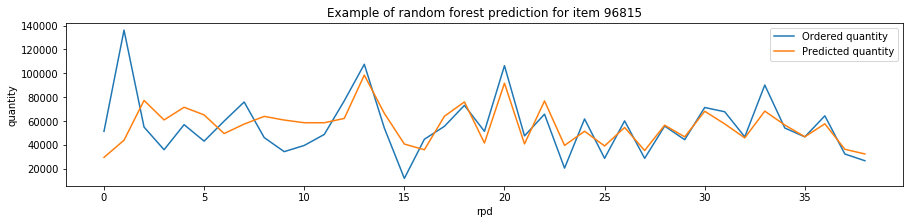

In [187]:
fig = plt.figure(figsize=(15,3))
plt.plot(np.array(y_quantity_item).ravel(), label = 'Ordered quantity')
plt.plot(y_predicted, label = 'Predicted quantity')
plt.xlabel('rpd')
plt.ylabel('quantity')
plt.title('Example of random forest prediction for item 96815')
plt.legend(); 
# ;
t = fig

### Now let's compare it with prediction without future_flag

In [70]:
X_quantity_item_wo_flag = X_quantity_item.loc[:,('0-0','0-96815')]

y_quantity_item = t[1].loc[108:151,('1-0',slice(None))]

In [71]:
y_predicted_wo_flag = []
for i in range(110,152):
    if (X_quantity_item_wo_flag.loc[i:i].size==0):
        continue
    else:
        regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100,warm_start = True)
        X_input = [X_quantity_item_wo_flag.loc[108:i]]
        #X_input = [X_quantity_item_wo_flag.loc[108:i].values,None]
#
        regr.fit(  np.array(X_input).transpose()  ,np.array(y_quantity_item).ravel()[0:(i-108)])
        #y_predicted_on_train.append(regr.predict(X_quantity_item.loc[(i):(i),:])[0])
        #y_predicted.append( regr.predict(X_quantity_item.loc[i:i,:])[0])
        if (X_quantity_item_wo_flag.loc[(i+1):(i+1)].size!=0):
            #print(X_quantity_item.loc[(i+1):(i+1),:])
            #print(regr.predict(X_quantity_item.loc[(i+1):(i+1),:])[0])
            X_test =np.array(X_quantity_item_wo_flag.loc[(i+1):(i+1)])
            y_predicted_wo_flag.append(regr.predict([X_test])[0] )

In [73]:
print("SMAPE: "+str(round(smape(np.array( y_quantity_item[2:]).ravel(), y_predicted_wo_flag),2)))

SMAPE: 0.37


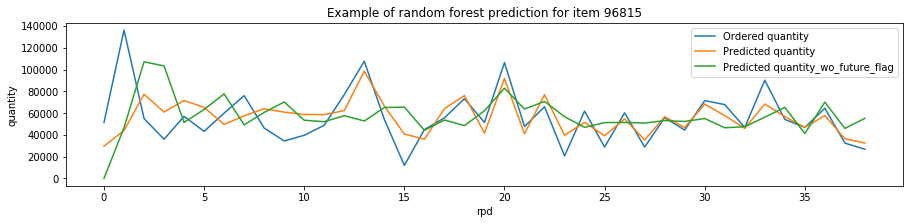

In [39]:
plt.figure(figsize=(15,3))
plt.plot(np.array(y_quantity_item[1:] ).ravel(), label = 'Ordered quantity')
plt.plot(y_predicted, label = 'Predicted quantity')
y_predicted_wo_flag.insert(0,0)
plt.plot(y_predicted_wo_flag , label = 'Predicted quantity_wo_future_flag')
plt.xlabel('rpd')
plt.ylabel('quantity')
plt.title('Example of random forest prediction for item 96815')
plt.legend(); 
# ;

### GradientBoostingRegressor

In [74]:
from sklearn.ensemble import GradientBoostingRegressor
y_predicted = []
X_quantity_item = t[0].loc[108:151,:]
y_quantity_item = t[1].loc[108:151,('1-0',slice(None))]
for i in range(108,152):
    if (X_quantity_item.loc[i:i,:].size==0):
        continue
    else:
        params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
        regr = GradientBoostingRegressor(**params)
        regr.fit(X_quantity_item.loc[108:i,:],np.array(y_quantity_item).ravel()[0:(i-108)])
        if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
            y_predicted.append( regr.predict(X_quantity_item.loc[(i+1):(i+1),:])[0])
print("SMAPE: "+str(round(smape(np.array( y_quantity_item[1:]).ravel(), y_predicted),2)))

SMAPE: 0.27


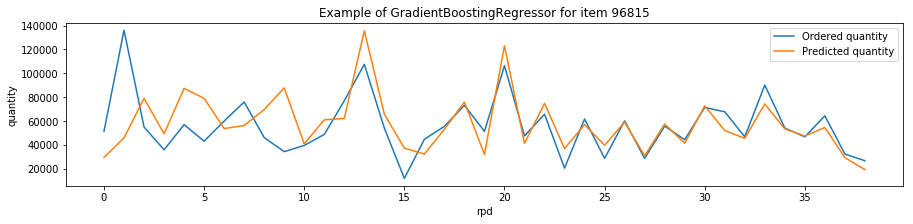

In [41]:
plt.figure(figsize=(15,3))
plt.plot(np.array(y_quantity_item[1:] ).ravel(), label = 'Ordered quantity')
plt.plot(y_predicted, label = 'Predicted quantity')
y_predicted_wo_flag.insert(0,0)
plt.xlabel('rpd')
plt.ylabel('quantity')
plt.title('Example of GradientBoostingRegressor for item 96815')
plt.legend(); 

### SVM Regression


In [77]:
from sklearn.svm import SVR
y_predicted = []
X_quantity_item = t[0].loc[108:151,:]
y_quantity_item = t[1].loc[108:151,('1-0',slice(None))]
for i in range(108,152):
    if (X_quantity_item.loc[i:i,:].size==0):
        continue
    else:
        regr = SVR(gamma=0.001, C=1.0, epsilon=0.2)
        regr.fit(X_quantity_item.loc[108:i,:],np.array(y_quantity_item).ravel()[0:(i-108)])
        if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
            y_predicted.append( regr.predict(X_quantity_item.loc[(i+1):(i+1),:])[0])
print("SMAPE: "+str(round(smape(np.array( y_quantity_item[1:]).ravel(), y_predicted),2)))

SMAPE: 0.34


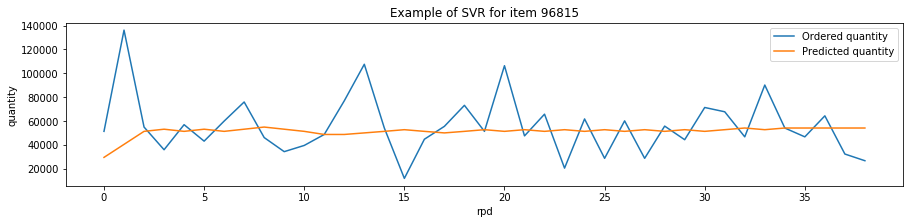

In [43]:
plt.figure(figsize=(15,3))
plt.plot(np.array(y_quantity_item[1:] ).ravel(), label = 'Ordered quantity')
plt.plot(y_predicted, label = 'Predicted quantity')
plt.xlabel('rpd')
plt.ylabel('quantity')
plt.title('Example of SVR for item 96815')
plt.legend(); 

### Kernel Regression

In [80]:
from sklearn.kernel_ridge import KernelRidge
y_predicted = []
X_quantity_item = t[0].loc[108:151,:]
y_quantity_item = t[1].loc[108:151,('1-0',slice(None))]
for i in range(108,152):
    if (X_quantity_item.loc[i:i,:].size==0):
        continue
    else:
        regr = KernelRidge(alpha=1.0)
        regr.fit(X_quantity_item.loc[108:i,:],np.array(y_quantity_item).ravel()[0:(i-108)])
        if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
            y_predicted.append( regr.predict(X_quantity_item.loc[(i+1):(i+1),:])[0])
print("SMAPE: "+str(round(smape(np.array( y_quantity_item[1:]).ravel(), y_predicted),2)))

SMAPE: 0.26


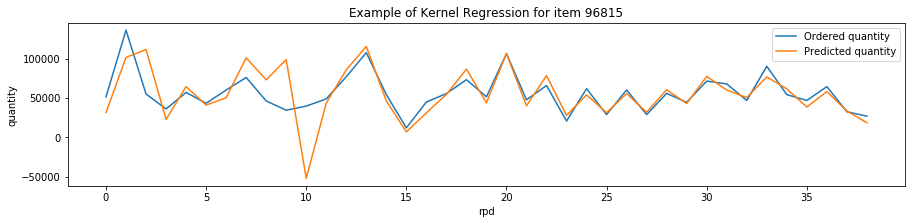

In [83]:
plt.figure(figsize=(15,3))
plt.plot(np.array(y_quantity_item[1:] ).ravel(), label = 'Ordered quantity')
plt.plot(y_predicted, label = 'Predicted quantity')
plt.xlabel('rpd')
plt.ylabel('quantity')
plt.title('Example of Kernel Regression for item 96815')
plt.legend(); 

### Let's estimate all Y using random forest

In [86]:
y_predicted = []
X_quantity_item = t[0].loc[108:151,:]
y_quantity_item = t[1]

In [87]:
y_pred_1_0 =[]
y_pred_2_0 = []
y_pred_2_1 = []
y_pred_3_0 = [] 
y_pred_3_1 = [] 
y_pred_3_2 = []
y_pred_4_0 = []
y_pred_4_1 = []
y_pred_4_2 = [] 
y_pred_4_3=[]

In [88]:
for i in range(108,152):
    if (X_quantity_item.loc[i:i,:].size==0):
        continue
    else:
        regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100,warm_start = True)
        regr.fit(X_quantity_item.loc[108:i,:],np.array(y_quantity_item.loc[108:i,('1-0',slice(None))]).ravel())
        if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
            y_pred_1_0.append( regr.predict(X_quantity_item.loc[(i+ 1):(i+1),:])[0])
        ## 
        regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100,warm_start = True)
        regr.fit(X_quantity_item.loc[108:i,:],np.array(y_quantity_item.loc[108:i,('2-0',slice(None))]).ravel())
        if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
            y_pred_2_0.append( regr.predict(X_quantity_item.loc[(i+ 1):(i+1),:])[0])
        ##         
        regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100,warm_start = True)
        regr.fit(X_quantity_item.loc[108:i,:],np.array(y_quantity_item.loc[108:i,('2-1',slice(None))]).ravel())
        if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
            y_pred_2_1.append( regr.predict(X_quantity_item.loc[(i+ 1):(i+1),:])[0])
        ## 
        regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100,warm_start = True)
        regr.fit(X_quantity_item.loc[108:i,:],np.array(y_quantity_item.loc[108:i,('3-0',slice(None))]).ravel())
        if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
            y_pred_3_0.append( regr.predict(X_quantity_item.loc[(i+ 1):(i+1),:])[0])
        ## 
        regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100,warm_start = True)
        regr.fit(X_quantity_item.loc[108:i,:],np.array(y_quantity_item.loc[108:i,('3-1',slice(None))]).ravel())
        if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
            y_pred_3_1.append( regr.predict(X_quantity_item.loc[(i+ 1):(i+1),:])[0])
        ## 
        regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100,warm_start = True)
        regr.fit(X_quantity_item.loc[108:i,:],np.array(y_quantity_item.loc[108:i,('3-2',slice(None))]).ravel())
        if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
            y_pred_3_2.append( regr.predict(X_quantity_item.loc[(i+ 1):(i+1),:])[0])
        ## 
        regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100,warm_start = True)
        regr.fit(X_quantity_item.loc[108:i,:],np.array(y_quantity_item.loc[108:i,('4-0',slice(None))]).ravel())
        if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
            y_pred_4_0.append( regr.predict(X_quantity_item.loc[(i+ 1):(i+1),:])[0])
        ## 
        regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100,warm_start = True)
        regr.fit(X_quantity_item.loc[108:i,:],np.array(y_quantity_item.loc[108:i,('4-1',slice(None))]).ravel())
        if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
            y_pred_4_1.append( regr.predict(X_quantity_item.loc[(i+ 1):(i+1),:])[0])
        ## 
        regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100,warm_start = True)
        regr.fit(X_quantity_item.loc[108:i,:],np.array(y_quantity_item.loc[108:i,('4-2',slice(None))]).ravel())
        if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
            y_pred_4_2.append( regr.predict(X_quantity_item.loc[(i+ 1):(i+1),:])[0])
        ##         
        regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100,warm_start = True)
        regr.fit(X_quantity_item.loc[108:i,:],np.array(y_quantity_item.loc[108:i,('4-3',slice(None))]).ravel())
        if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
            y_pred_4_3.append( regr.predict(X_quantity_item.loc[(i+ 1):(i+1),:])[0])
        ##         
        

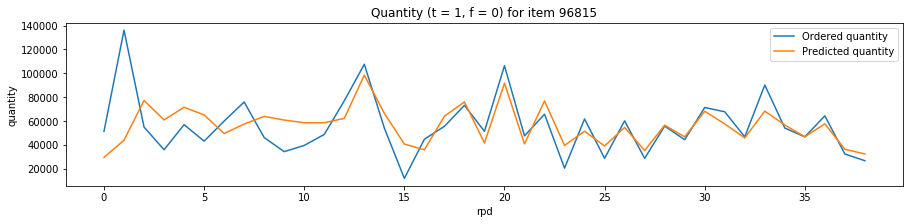

In [89]:
plt.figure(figsize=(15,3))
plt.plot(np.array(y_quantity_item.loc[:,('1-0',slice(None))])[1:], label = 'Ordered quantity')
plt.plot(y_pred_1_0, label = 'Predicted quantity')
plt.xlabel('rpd')
plt.ylabel('quantity')
plt.title('Quantity (t = 1, f = 0) for item 96815')
plt.legend(); 

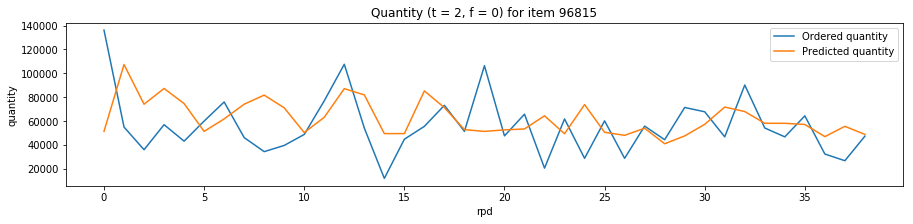

In [90]:
plt.figure(figsize=(15,3))
plt.plot(np.array(y_quantity_item.loc[:,('2-0',slice(None))])[1:], label = 'Ordered quantity')
plt.plot(y_pred_2_0, label = 'Predicted quantity')
plt.xlabel('rpd')
plt.ylabel('quantity')
plt.title('Quantity (t = 2, f = 0) for item 96815')
plt.legend(); 

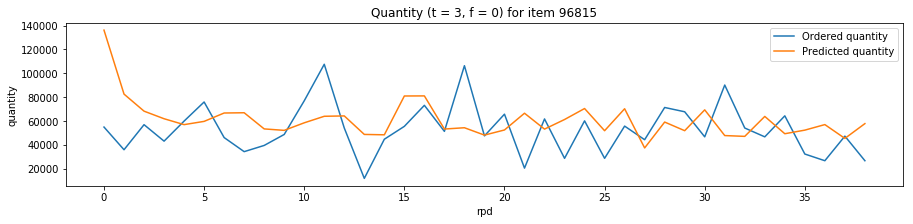

In [91]:
plt.figure(figsize=(15,3))
plt.plot(np.array(y_quantity_item.loc[:,('3-0',slice(None))])[1:], label = 'Ordered quantity')
plt.plot(y_pred_3_0, label = 'Predicted quantity')
plt.xlabel('rpd')
plt.ylabel('quantity')
plt.title('Quantity (t = 3, f = 0) for item 96815')
plt.legend(); 

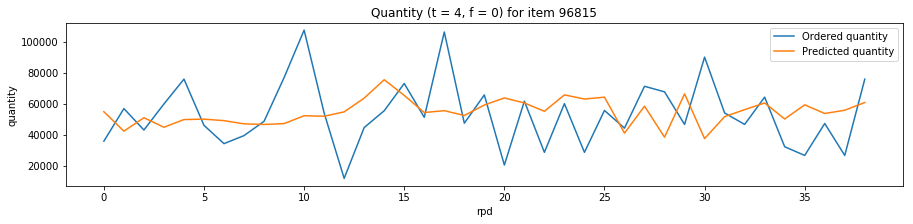

In [92]:
plt.figure(figsize=(15,3))
plt.plot(np.array(y_quantity_item.loc[:,('4-0',slice(None))])[1:], label = 'Ordered quantity')
plt.plot(y_pred_4_0, label = 'Predicted quantity')
plt.xlabel('rpd')
plt.ylabel('quantity')
plt.title('Quantity (t = 4, f = 0) for item 96815')
plt.legend(); 

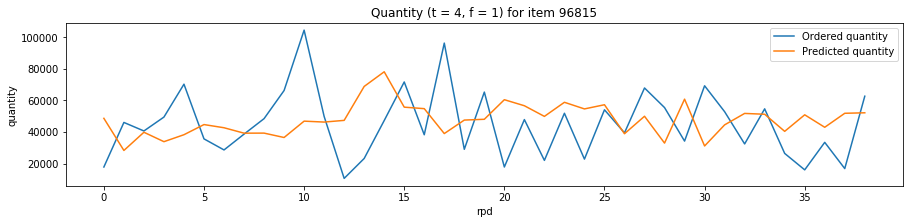

In [54]:
plt.figure(figsize=(15,3))
plt.plot(np.array(y_quantity_item.loc[:,('4-1',slice(None))])[1:], label = 'Ordered quantity')
plt.plot(y_pred_4_1, label = 'Predicted quantity')
plt.xlabel('rpd')
plt.ylabel('quantity')
plt.title('Quantity (t = 4, f = 1) for item 96815')
plt.legend(); 

In [100]:
print("SMAPE: "+str(round(smape(np.array(y_quantity_item.loc[:,('4-1',slice(None))])[1:].ravel(), y_pred_4_1),2)))

SMAPE: 0.47


In [99]:
np.array(y_quantity_item.loc[:,('4-1',slice(None))])[1:].ravel()

array([ 17800.,  46000.,  40600.,  49400.,  70200.,  35600.,  28600.,
        38600.,  48400.,  66200., 104400.,  49800.,  10600.,  23200.,
        47200.,  71600.,  38200.,  96200.,  29000.,  65200.,  17800.,
        47800.,  22000.,  51800.,  22800.,  54000.,  39400.,  67800.,
        55400.,  34200.,  69200.,  52800.,  32400.,  54600.,  26400.,
        16000.,  33400.,  16800.,  62600.])

SMAPE for all Y

In [115]:
np.array([[0,0,0,0],
         [round(smape(np.array(y_quantity_item.loc[:,('1-0',slice(None))])[1:].ravel(), y_pred_1_0),2),
          0,0,0],
         [round(smape(y_pred_2_0,np.array(y_quantity_item.loc[:,('2-0',slice(None))])[1:].ravel()),2),
          round(smape(np.array(y_quantity_item.loc[:,('2-1',slice(None))])[1:].ravel(), y_pred_2_1),2),
          0,0],
         [round(smape(np.array(y_quantity_item.loc[:,('3-0',slice(None))])[1:].ravel(), y_pred_3_0),2),
          round(smape(np.array(y_quantity_item.loc[:,('3-1',slice(None))])[1:].ravel(), y_pred_3_1),2),
          round(smape(np.array(y_quantity_item.loc[:,('3-2',slice(None))])[1:].ravel(), y_pred_3_2),2),
          0],
         [round(smape(np.array(y_quantity_item.loc[:,('4-0',slice(None))])[1:].ravel(), y_pred_4_0),2),
          round(smape(np.array(y_quantity_item.loc[:,('4-1',slice(None))])[1:].ravel(), y_pred_4_1),2),
          round(smape(np.array(y_quantity_item.loc[:,('4-2',slice(None))])[1:].ravel(), y_pred_4_2),2),
          round(smape(np.array(y_quantity_item.loc[:,('4-3',slice(None))])[1:].ravel(), y_pred_4_3),2)]])

array([[0.  , 0.  , 0.  , 0.  ],
       [0.26, 0.  , 0.  , 0.  ],
       [0.38, 0.46, 0.  , 0.  ],
       [0.38, 0.45, 0.63, 0.  ],
       [0.35, 0.47, 0.8 , 1.14]])

Let's try all items

In [118]:
all_items = set(df.index.get_level_values('item'))
mse_per_item = {}
plot_per_item = {}
for it in all_items:
    item_ = df.filter(like=str(it),axis = 0)
    demand_total_item = item_["quantity_ecd"].unstack(fill_value=0)
    qty_total_item = demand_total_item.unstack("item", fill_value=0.)
    t = make_Xy(qty_total_item)
    y_predicted = []
    X_quantity_item = t[0].loc[108:151,:]
    y_quantity_item = t[1].loc[108:151,('1-0',slice(None))]
    for i in range(108,152):
        if (X_quantity_item.loc[i:i,:].size==0):
            continue
        else:
            regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100,warm_start = True)
            regr.fit(X_quantity_item.loc[108:i,:],np.array(y_quantity_item.loc[108:i,:]).ravel())
            if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
                y_predicted.append( regr.predict(X_quantity_item.loc[(i+1):(i+1),:])[0])
    plot_per_item [it] = plt_2_gr(y_quantity_item,y_predicted,'Item '+str(it)+' Random Forest')
    plt.close()
    if (len(y_predicted)>1):
        mse_per_item[it]=round(smape(np.array(y_quantity_item[1:len(y_predicted)+1]).ravel(), y_predicted),1)
    #break

In [120]:
#but mse all also depends on the amount of volume of shipment. Should normalize?
from collections import OrderedDict
from operator import itemgetter
d = OrderedDict(sorted(mse_per_item.items(), key=itemgetter(1)))
i = 0
for idx in d.keys():
    if (i>5):
        break
    print(idx,d[idx])
    i+=1

35996 0.0
22660 0.2
37032 0.2
12486 0.2
26851 0.2
53787 0.2


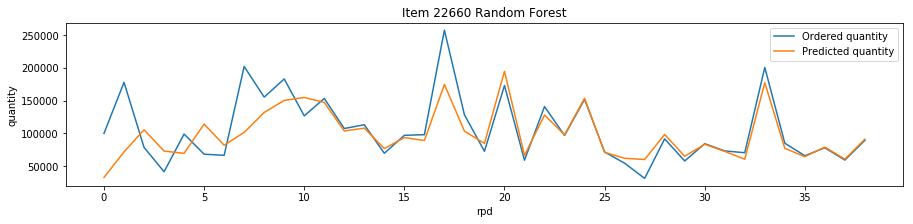

In [124]:
plot_per_item[22660]

In [122]:
i = 0
for idx in reversed(d.keys()):
    if (i>5):
        break
    print(idx,d[idx])
    i+=1

15673 1.8
97339 1.8
78653 1.8
87828 1.6
52471 1.6
57302 1.5


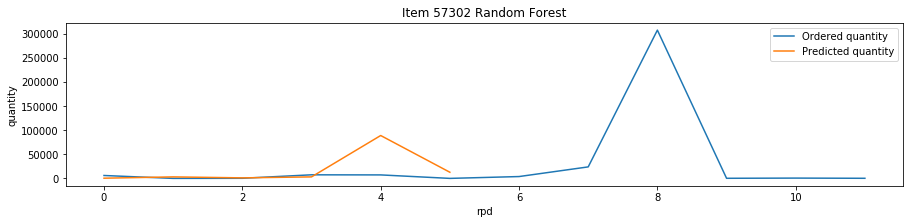

In [123]:
plot_per_item[57302]

### Let's try to generalize prediction process

1. No data Transformation.
2. Random Forest
3. y0-y4
4. '#' of rpd > 38

In [3]:
from collections import defaultdict

In [4]:
def prediction_randomforest(df):
    df = df.set_index(["item", "rpd", "future_flag"]).sort_index()
    all_items = set(df.index.get_level_values('item'))
    smape_per_item = defaultdict()
    plot_per_item = defaultdict()
    for it in all_items:

        item_ = df.filter(like=str(it),axis = 0)
        #It was stated that skip all items, for which # of rpd<38  (around 120 from 720 items)
        if item_.groupby('rpd').ngroups<38:
            continue
        demand_total_item = item_["quantity_ecd"].unstack(fill_value=0)
        qty_total_item = demand_total_item.unstack("item", fill_value=0.)
        t = make_Xy(qty_total_item)
        y_predicted = []
        y_predicted.append([])
        y_predicted.append([])
        y_predicted.append([])
        y_predicted.append([])
        X_quantity_item = t[0].loc[108:151,:]
        y_quantity_item = []
        for i in range(1,5):
            y_quantity_item.append(t[1].loc[108:151,(str(i)+'-0',slice(None))]) 
        for i in range(108,152):
            if (X_quantity_item.loc[i:i,:].size==0):
                continue
            else:
                for ii in range(1,5):
                    regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100,warm_start = True)
                    regr.fit(X_quantity_item.loc[108:i,:],np.array(y_quantity_item[ii-1].loc[108:i,:]).ravel())
                    if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
                        y_predicted[ii-1].append(regr.predict(X_quantity_item.loc[(i+1):(i+1),:])[0])
                        
        plot_per_item [it] = (plt_2_gr(y_quantity_item[0],y_predicted[0],'Item '+str(it)+' Random Forest. y_1_0'),
                              plt_2_gr(y_quantity_item[1],y_predicted[1],'Item '+str(it)+' Random Forest. y_2_0'),
                              plt_2_gr(y_quantity_item[2],y_predicted[2],'Item '+str(it)+' Random Forest. y_3_0'),
                              plt_2_gr(y_quantity_item[3],y_predicted[3],'Item '+str(it)+' Random Forest. y_4_0'))
                              
        plt.close()
        #if (len(y_predicted)>1):
        smape_per_item[it]=(round(smape(np.array(y_quantity_item[0][1:len(y_predicted[0])+1]).ravel(), y_predicted[0]),1),
                            round(smape(np.array(y_quantity_item[1][1:len(y_predicted[1])+1]).ravel(), y_predicted[1]),1),
                            round(smape(np.array(y_quantity_item[2][1:len(y_predicted[2])+1]).ravel(), y_predicted[2]),1),
                            round(smape(np.array(y_quantity_item[3][1:len(y_predicted[3])+1]).ravel(), y_predicted[3]),1))
        break 
    return smape_per_item,plot_per_item

In [5]:
df = pd.read_csv("demand_out_encoded_stage_3.csv", header=0, index_col=None)
smapes_randomforest, plots_randomforest = prediction_randomforest(df)

NameError: name 'RandomForestRegressor' is not defined

In [261]:
smapes_randomforest.items()

dict_items([(94208, (0.6, 0.7, 0.7, 0.7)), (67590, (1.0, 1.0, 1.0, 1.0)), (81961, (1.2, 1.2, 1.0, 1.0)), (89970, (0.9, 1.0, 1.0, 1.1)), (98366, (0.5, 0.7, 0.8, 0.8)), (47200, (0.3, 0.4, 0.5, 0.5)), (49255, (0.8, 0.7, 0.9, 1.2)), (79977, (0.7, 0.9, 1.0, 0.9)), (22660, (0.2, 0.4, 0.5, 0.5)), (18566, (0.5, 0.8, 0.9, 0.8)), (37032, (0.2, 0.4, 0.4, 0.4)), (12486, (0.2, 0.4, 0.4, 0.4)), (26851, (0.2, 0.4, 0.4, 0.5)), (24819, (0.6, 0.7, 0.6, 0.7)), (92422, (0.8, 0.8, 0.7, 0.8)), (51502, (0.4, 0.6, 0.6, 0.7)), (86323, (0.3, 0.6, 0.6, 0.6)), (63798, (0.8, 1.0, 0.9, 1.0)), (35165, (1.1, 1.1, 1.0, 1.0)), (86372, (1.0, 1.1, 1.0, 1.1)), (35249, (0.8, 0.9, 1.0, 1.0)), (86485, (0.3, 0.4, 0.4, 0.3)), (70108, (0.3, 0.4, 0.4, 0.4)), (63972, (0.7, 1.0, 0.9, 0.9)), (37370, (0.7, 0.8, 0.8, 0.9)), (20999, (0.9, 0.8, 0.9, 0.9)), (53787, (0.2, 0.4, 0.4, 0.4)), (96815, (0.3, 0.4, 0.4, 0.3)), (21042, (0.4, 0.6, 0.7, 0.8)), (74307, (0.5, 0.9, 0.9, 0.9)), (66120, (0.9, 1.2, 1.0, 1.1)), (47722, (1.0, 0.8, 0.7, 0.7

### Report for Friday Meeting

Random forest

In [361]:
from sklearn.ensemble import RandomForestRegressor
from collections import defaultdict
def prediction_randomforest_values(df):
    df = df.set_index(["item", "rpd", "future_flag"]).sort_index()
    all_items = set(df.index.get_level_values('item'))
    y_predicted = defaultdict()
    y_true = defaultdict()
    y_quantity_item = defaultdict()
    for it in all_items:
        item_ = df.filter(like=str(it),axis = 0)
        #It was stated that skip all items, for which # of rpd<38  (around 120 from 720 items)
        if item_.groupby('rpd').ngroups!=44:
            continue
        demand_total_item = item_["quantity_ecd"].unstack(fill_value=0)
        qty_total_item = demand_total_item.unstack("item", fill_value=0.)
        t = make_Xy(qty_total_item)
        y_predicted[it]=[]
        y_true[it]=[]
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        X_quantity_item = t[0].loc[108:151,:]
        y_quantity_item[it]=[]
        for i in range(1,5):
            y_quantity_item[it].append(t[1].loc[108:151,(str(i)+'-0',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('2-1',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('3-1',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('3-2',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('4-1',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('4-2',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('4-3',slice(None))])
        y_true[it] = t[1].loc[140:151].reindex(columns=[('1-0','1-'+str(it)) ,('2-0','2-'+str(it)),('3-0','3-'+str(it))  ,('4-0','4-'+str(it)) ,('2-1','2-'+str(it)) ,('3-1','3-'+str(it)) ,('3-2','3-'+str(it)),('4-1','4-'+str(it)) ,('4-2','4-'+str(it)) ,('4-3','4-'+str(it)) ])
        y_true[it]=y_true[it].append(pd.DataFrame(index = set([140, 141, 142, 143, 144, 145, 146, 147, 148]).difference(y_true[it].index))).sort_index()
        for i in range(139,151): #139
            if (X_quantity_item.loc[i:i,:].size==0):
                continue
            else:
                for ii in range(1,11):
                    regr = RandomForestRegressor(max_depth=3,n_estimators=100)
                    regr.fit(X_quantity_item.loc[108:i,:],np.array(y_quantity_item[it][ii-1].loc[108:i,:]).ravel())
                    #if y_true[it].values[i-139][ii-1]= np.nan:
                     #   y_predicted[it][ii-1].append(np.nan)
                    #else:
                    if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
                        #print(i-139,ii-1,y_true[it].values[i-139][ii-1])
                        y_predicted[it][ii-1].append(regr.predict(X_quantity_item.loc[(i+1):(i+1),:])[0])
        y_predicted[it]=pd.DataFrame(np.array(y_predicted[it]).transpose())#.applymap(int)
        break
    return y_predicted,y_true


In [178]:
#The function, that will transform this to big dataframe and save to csv
# concat for every item
def print_to_csv(y_predicted,y_true,method_name = "test"):
    needed_values = [(3,0),(4,0),(5,0),(6,0),(7,0),(8,0),(8,1),(8,2),(8,3),(2,4),(3,4),(4,4),(5,4),(6,4),(7,4),(8,4),(8,5),(8,7),(1,6),(2,6),(3,6),(4,6),(5,6),(6,6),(7,6),(8,6),(8,8),(0,9),(1,9),(2,9),(3,9),(4,9),(5,9),(6,9),(7,9),(8,9)]
    exp = pd.DataFrame(columns=['item','rpd','future_flag','true_value','predicted','method'])
    for it in y_predicted.keys():
        true_values = []
        predicted_values = []
        for x in needed_values:
            true_values.append(y_true[it].values[x[0]][x[1]])
            predicted_values.append(y_predicted[it][x[1]][x[0]])
        #create row of 
        row_of_prediction = [y_true[it]]
        i = 0
        for ff in range(0,4):
            for rpd in range(143,152):
                d1 = pd.DataFrame([[it,rpd,ff,true_values[i],predicted_values[i],method_name]], columns=['item','rpd','future_flag','true_value','predicted','method'])
                i+=1
                exp = exp.append(d1)
    exp = exp.set_index(["item", "rpd", "future_flag"]).sort_index()
    exp.to_csv(method_name+'.csv')
    return exp.drop(columns = ["method","predicted"]).reset_index(),exp.drop(columns = ["method","true_value"]).reset_index()

In [333]:
# Function, which creates plots
import matplotlib
import matplotlib.lines as mlines
import matplotlib.backends.backend_pdf
import matplotlib.transforms as mtransforms
def plot_hist(plot_array,message = "",close = 1):
    pdf = matplotlib.backends.backend_pdf.PdfPages("plots/"+message+"pdf")
    
    for i in range(0,4):
        smape_res = smape_(plot_array[i][0], plot_array[i][1], mean = False)
        fig, ax = plt.subplots(figsize = (5, 6))
        plt.hist(smape_res)
        plt.axvline(smape_res.mean(), color='r', linestyle='dashed', linewidth=1)
        ax.set_xlabel('SMAPE, %. '+message+' Flag = '+str(i)+'.')
        plt.savefig('plots/Hist. '+message+' Flag = '+str(i)+'.jpg',dpi =300)
        ax.annotate('Mean SMAPE = '+str(int(smape_res.mean()))+" %",
            xy=(smape_res.mean(), ax.get_ylim()[1]), xytext=(smape_res.mean()+(ax.get_xlim()[1]-ax.get_xlim()[0])*0.07, ax.get_ylim()[1]*1.015),
            arrowprops=dict(facecolor='black', shrink=0.1),
            annotation_clip=False)
        pdf.savefig(ax.figure,dpi = 300)
        if (close ==1):
            plt.close()
                        
    for i in range(0,4):
        test_flat = plot_array[i][0].values.flatten()
        predicted_flat = plot_array[i][1].values.flatten()
        fig, ax = plt.subplots(figsize = (5, 6))
        plt.scatter(predicted_flat, test_flat)
        ax.set_xlabel('Predicted values')
        ax.set_ylabel('True values')
        line = mlines.Line2D([0, 1], [0, 1],linewidth = 1.0, color='black',linestyle='dashed')
        transform = ax.transAxes
        line.set_transform(transform)
        ax.add_line(line)
        ax.set_xscale('symlog')
        ax.set_yscale('symlog')
        ax.set_title(message+' Flag = '+str(i)+'.')
        plt.savefig('plots/Scatter. '+message+' Flag = '+str(i)+'.jpg',dpi =300)            
        pdf.savefig(ax.figure,dpi = 300)
        if (close ==1):
            plt.close()    
    pdf.close()

In [225]:
# Splits into dataframe into future_flag dataframes for plotting
import matplotlib.pyplot as plt
def create_dataset(df, df_0, future_flag):
    items = df.item.unique()
    df = df[df['future_flag'] == future_flag]
    df = df.groupby(['rpd', 'item']).sum().reset_index().drop('future_flag', axis = 1)
    for item in items:
        tmp = df[df['item'] == item].drop('item', axis = 1)
        tmp.columns = ['rpd', str(item)]
        df_0 = df_0.merge(tmp, on = 'rpd', how = 'left')
    df_0.set_index('rpd', inplace = True)
    return df_0

def create_dataframes_for_plots(df):
    df_0 = pd.DataFrame(df.rpd.unique())
    df_0.columns = ['rpd']
    df_0.sort_values(by = 'rpd', ascending = True, inplace = True)
    df_flag_0 = create_dataset(df, df_0, 0) # dataset for future_flag = 0 
    df_flag_1 = create_dataset(df, df_0, 1) # dataset for future_flag = 1
    df_flag_2 = create_dataset(df, df_0, 2) # dataset for future_flag = 2 
    df_flag_3 = create_dataset(df, df_0, 3) # dataset for future_flag = 3
    return df_flag_0,df_flag_1,df_flag_2,df_flag_3
def smape_(y_true, y_pred, mean = True):
    #smape = 2 * np.sum(np.abs(y_pred-y_true) / np.abs(y_true + y_pred), axis = 0)*100   
    smape = 2 * np.sum(np.abs(y_pred-y_true) / np.abs(y_true + y_pred), axis = 0)*100/len(y_pred)
    if mean == True:
        smape = smape.mean()
    return smape
#  * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))/len(A)

In [362]:
df = pd.read_csv("demand_out_encoded_stage_3.csv", header=0, index_col=None)
y_predicted_tree, y_true_tree = prediction_randomforest_values(df)

future_flag       0-0       0-1       0-2      0-3       1-1       1-2  \
item          0-98366   0-98366   0-98366  0-98366   1-98366   1-98366   
rpd                                                                      
109           23000.0     400.0       0.0      0.0   14800.0    4800.0   
110           15800.0   14800.0    4800.0   4800.0   23800.0   20000.0   
111           54200.0   23800.0   20000.0   9800.0   48800.0       0.0   
112           58000.0   48800.0       0.0      0.0   22000.0    8400.0   
113           24600.0   22000.0    8400.0      0.0    6000.0    4800.0   
114            6600.0    6000.0    4800.0   3400.0   48400.0   22800.0   
115           52000.0   48400.0   22800.0  22800.0   28800.0   21200.0   
116           29800.0   28800.0   21200.0  21000.0    2600.0     400.0   
117            9000.0    2600.0     400.0      0.0   26600.0    8000.0   
118           27600.0   26600.0    8000.0      0.0    6800.0       0.0   
119            8200.0    6800.0       

TypeError: cannot unpack non-iterable NoneType object

In [230]:
rf_true,rf_pred  = print_to_csv(y_predicted_tree,y_true_tree,"random_forest")
rf_true_0,rf_true_1,rf_true_2,rf_true_3 = create_dataframes_for_plots(rf_true)
rf_pred_0,rf_pred_1,rf_pred_2,rf_pred_3= create_dataframes_for_plots(rf_pred)
plot_array = [(rf_true_0,rf_pred_0),(rf_true_1,rf_pred_1),(rf_true_2,rf_pred_2),(rf_true_3,rf_pred_3)]

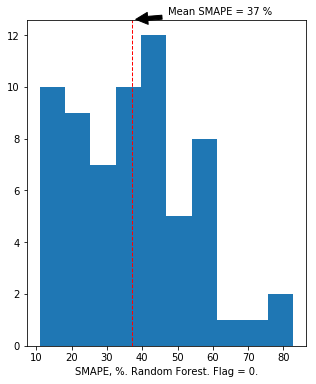

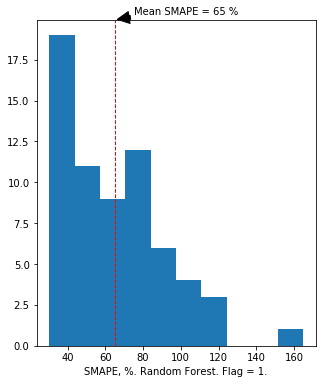

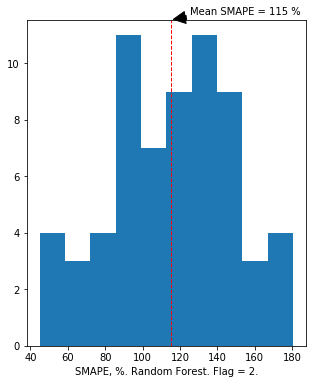

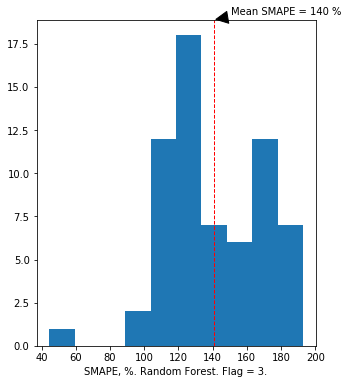

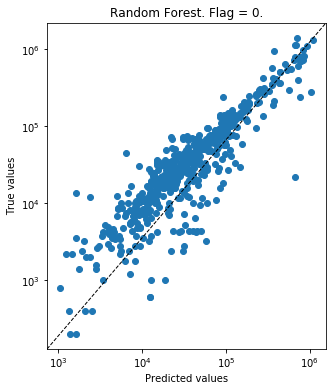

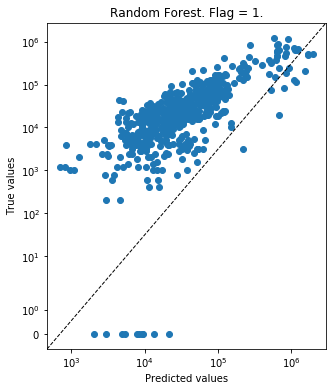

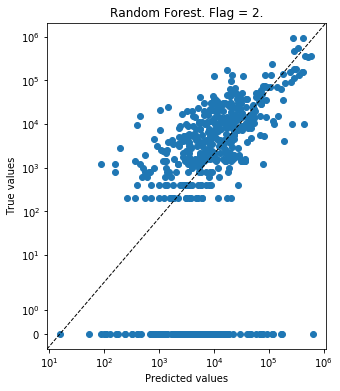

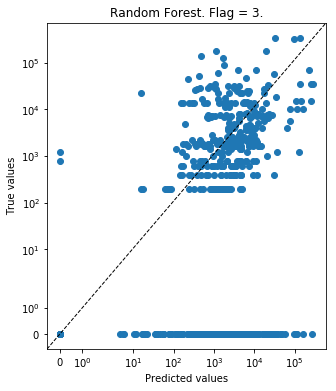

In [122]:
plot_hist(plot_array, "Random Forest.",0)

### Random forest minmax

In [11]:
from sklearn.ensemble import RandomForestRegressor
from collections import defaultdict
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
def prediction_randomforest_minmax_values(df):
    df = df.set_index(["item", "rpd", "future_flag"]).sort_index()
    all_items = set(df.index.get_level_values('item'))
    y_predicted = defaultdict()
    y_true = defaultdict()
    y_quantity_item = defaultdict()
    for it in all_items:
        item_ = df.filter(like=str(it),axis = 0)
        #It was stated that skip all items, for which # of rpd<38  (around 120 from 720 items)
        if item_.groupby('rpd').ngroups!=44:
            continue
        demand_total_item = item_["quantity_ecd"].unstack(fill_value=0)
        qty_total_item = demand_total_item.unstack("item", fill_value=0.)
        t = make_Xy(qty_total_item)
        y_predicted[it]=[]
        y_true[it]=[]
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        X_quantity_item = t[0].loc[108:151,:]
        y_quantity_item[it]=[]
        for i in range(1,5):
            y_quantity_item[it].append(t[1].loc[108:151,(str(i)+'-0',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('2-1',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('3-1',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('3-2',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('4-1',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('4-2',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('4-3',slice(None))])
        y_true[it] = t[1].loc[140:151].reindex(columns=[('1-0','1-'+str(it)) ,('2-0','2-'+str(it)),('3-0','3-'+str(it))  ,('4-0','4-'+str(it)) ,('2-1','2-'+str(it)) ,('3-1','3-'+str(it)) ,('3-2','3-'+str(it)),('4-1','4-'+str(it)) ,('4-2','4-'+str(it)) ,('4-3','4-'+str(it)) ])
        y_true[it]=y_true[it].append(pd.DataFrame(index = set([140, 141, 142, 143, 144, 145, 146, 147, 148]).difference(y_true[it].index))).sort_index()
        for i in range(139,151): #139
            if (X_quantity_item.loc[i:i,:].size==0):
                continue
            else:
                for ii in range(1,11):
                    regr = RandomForestRegressor(max_depth=3,n_estimators=100)
                    scaler_x = MinMaxScaler()
                    X_scaled= scaler_x.fit_transform(X_quantity_item.loc[108:i,:])
                    scaler_y = MinMaxScaler()
                    Y_scaled = scaler_y.fit_transform(y_quantity_item[it][ii-1].loc[108:i,:])
                    regr.fit(X_scaled,np.array(Y_scaled).ravel())
                    if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
                        scaled_prediction = regr.predict(scaler_x.transform(X_quantity_item.loc[(i+1):(i+1),:]))[0]
                        y_predicted[it][ii-1].append(   scaler_y.inverse_transform(scaled_prediction)[0][0])
                        
        y_predicted[it]=pd.DataFrame(np.array(y_predicted[it]).transpose())#.applymap(int)
    return y_predicted,y_true

In [12]:
df = pd.read_csv("demand_out_encoded_stage_3.csv", header=0, index_col=None)
y_predicted_rf_minmax, y_true_rf_minmax = prediction_randomforest_minmax_values(df)

In [13]:
rf_minmax_true,rf_minmax_pred  = print_to_csv(y_predicted_rf_minmax,y_true_rf_minmax,"random_forest_minmax")
rf_true_0,rf_true_1,rf_true_2,rf_true_3 = create_dataframes_for_plots(rf_minmax_true)
rf_pred_0,rf_pred_1,rf_pred_2,rf_pred_3= create_dataframes_for_plots(rf_minmax_pred)
plot_array = [(rf_true_0,rf_pred_0),(rf_true_1,rf_pred_1),(rf_true_2,rf_pred_2),(rf_true_3,rf_pred_3)]
plot_hist(plot_array, "Random Forest. MinMax.")

### Random forest log transform

In [14]:
from sklearn.ensemble import RandomForestRegressor
from collections import defaultdict
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
def prediction_randomforest_logtransform(df):
    df = df.set_index(["item", "rpd", "future_flag"]).sort_index()
    all_items = set(df.index.get_level_values('item'))
    y_predicted = defaultdict()
    y_true = defaultdict()
    y_quantity_item = defaultdict()
    for it in all_items:
        item_ = df.filter(like=str(it),axis = 0)
        #It was stated that skip all items, for which # of rpd<38  (around 120 from 720 items)
        if item_.groupby('rpd').ngroups!=44:
            continue
        demand_total_item = item_["quantity_ecd"].unstack(fill_value=0)
        qty_total_item = demand_total_item.unstack("item", fill_value=0.)
        t = make_Xy(qty_total_item)
        y_predicted[it]=[]
        y_true[it]=[]
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        X_quantity_item = t[0].loc[108:151,:]
        y_quantity_item[it]=[]
        for i in range(1,5):
            y_quantity_item[it].append(t[1].loc[108:151,(str(i)+'-0',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('2-1',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('3-1',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('3-2',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('4-1',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('4-2',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('4-3',slice(None))])
        y_true[it] = t[1].loc[140:151].reindex(columns=[('1-0','1-'+str(it)) ,('2-0','2-'+str(it)),('3-0','3-'+str(it))  ,('4-0','4-'+str(it)) ,('2-1','2-'+str(it)) ,('3-1','3-'+str(it)) ,('3-2','3-'+str(it)),('4-1','4-'+str(it)) ,('4-2','4-'+str(it)) ,('4-3','4-'+str(it)) ])
        y_true[it]=y_true[it].append(pd.DataFrame(index = set([140, 141, 142, 143, 144, 145, 146, 147, 148]).difference(y_true[it].index))).sort_index()
        for i in range(139,151): #139
            if (X_quantity_item.loc[i:i,:].size==0):
                continue
            else:
                for ii in range(1,11):
                    regr = RandomForestRegressor(max_depth=3,n_estimators=100)
                    
                    X_scaled= np.log1p(X_quantity_item.loc[108:i,:])
                    regr.fit(X_scaled,np.log1p(np.array(y_quantity_item[it][ii-1].loc[108:i,:])).ravel())
                    if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
                        y_predicted[it][ii-1].append(np.expm1 (regr.predict(np.log1p(X_quantity_item.loc[(i+1):(i+1),:]))[0]))
        y_predicted[it]=pd.DataFrame(np.array(y_predicted[it]).transpose())#.applymap(int)
    return y_predicted,y_true

In [15]:
df = pd.read_csv("demand_out_encoded_stage_3.csv", header=0, index_col=None)
y_predicted_rf_logtransform, y_true_rf_logtransform = prediction_randomforest_logtransform(df)

In [16]:
rf_log_true,rf_log_pred  = print_to_csv(y_predicted_rf_logtransform,y_true_rf_logtransform,"random_forest_logtran")
rf_true_0,rf_true_1,rf_true_2,rf_true_3 = create_dataframes_for_plots(rf_log_true)
rf_pred_0,rf_pred_1,rf_pred_2,rf_pred_3= create_dataframes_for_plots(rf_log_pred)
plot_array = [(rf_true_0,rf_pred_0),(rf_true_1,rf_pred_1),(rf_true_2,rf_pred_2),(rf_true_3,rf_pred_3)]
plot_hist(plot_array, "Random Forest. Log Transform.")

### Poisson.

In [94]:
import xgboost
from sklearn.model_selection import GridSearchCV
def prediction_poisson_values(df):
    df = df.set_index(["item", "rpd", "future_flag"]).sort_index()
    all_items = set(df.index.get_level_values('item'))
    y_predicted = defaultdict()
    y_true = defaultdict()
    y_quantity_item = defaultdict()
    for it in all_items:
        item_ = df.filter(like=str(it),axis = 0)
        #It was stated that skip all items, for which # of rpd<38  (around 120 from 720 items)
        if item_.groupby('rpd').ngroups!=44:
            continue
        demand_total_item = item_["quantity_ecd"].unstack(fill_value=0)
        qty_total_item = demand_total_item.unstack("item", fill_value=0.)
        t = make_Xy(qty_total_item)
        y_predicted[it]=[]
        y_true[it]=[]
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        X_quantity_item = t[0].loc[108:151,:]
        y_quantity_item[it]=[]
        for i in range(1,5):
            y_quantity_item[it].append(t[1].loc[108:151,(str(i)+'-0',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('2-1',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('3-1',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('3-2',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('4-1',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('4-2',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('4-3',slice(None))])
        y_true[it] = t[1].loc[140:151].reindex(columns=[('1-0','1-'+str(it)) ,('2-0','2-'+str(it)),('3-0','3-'+str(it))  ,('4-0','4-'+str(it)) ,('2-1','2-'+str(it)) ,('3-1','3-'+str(it)) ,('3-2','3-'+str(it)),('4-1','4-'+str(it)) ,('4-2','4-'+str(it)) ,('4-3','4-'+str(it)) ])
        y_true[it]=y_true[it].append(pd.DataFrame(index = set([140, 141, 142, 143, 144, 145, 146, 147, 148]).difference(y_true[it].index))).sort_index()
        for i in range(139,151): #139
            if (X_quantity_item.loc[i:i,:].size==0):
                continue
            else:
                for ii in range(1,11):                                        
                    XX =X_quantity_item.loc[108:i,:].applymap(int).values
                    y = np.array((y_quantity_item[it][ii-1].loc[108:i,:].applymap(int))).ravel()
                    regr =  xgboost.XGBRegressor( params={"objective": "count:poisson"},num_boost_round=100000,early_stopping_rounds=5,verbose_eval=False)
                    regr.fit(XX,y)
                    if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
                        XX_test = regr.predict( X_quantity_item.loc[(i+1):(i+1),:].applymap(int).values)[0]
                        y_predicted[it][ii-1].append(XX_test.clip(min=0))
        y_predicted[it]=pd.DataFrame(np.array(y_predicted[it]).transpose())#.applymap(int)
    return y_predicted,y_true

In [95]:
df = pd.read_csv("demand_out_encoded_stage_3.csv", header=0, index_col=None)
y_predicted_poisson, y_true_poisson = prediction_poisson_values(df)

In [96]:
true_,pred_  = print_to_csv(y_predicted_poisson,y_true_poisson,"poisson_regression")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Poisson Regression.")

### Poisson. MinMax.

In [14]:
import xgboost
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
def prediction_poisson_minmax_values(df):
    df = df.set_index(["item", "rpd", "future_flag"]).sort_index()
    all_items = set(df.index.get_level_values('item'))
    y_predicted = defaultdict()
    y_true = defaultdict()
    y_quantity_item = defaultdict()
    for it in all_items:
        item_ = df.filter(like=str(it),axis = 0)
        #It was stated that skip all items, for which # of rpd<38  (around 120 from 720 items)
        if item_.groupby('rpd').ngroups!=44:
            continue
        demand_total_item = item_["quantity_ecd"].unstack(fill_value=0)
        qty_total_item = demand_total_item.unstack("item", fill_value=0.)
        t = make_Xy(qty_total_item)
        y_predicted[it]=[]
        y_true[it]=[]
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        X_quantity_item = t[0].loc[108:151,:]
        y_quantity_item[it]=[]
        for i in range(1,5):
            y_quantity_item[it].append(t[1].loc[108:151,(str(i)+'-0',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('2-1',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('3-1',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('3-2',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('4-1',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('4-2',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('4-3',slice(None))])
        y_true[it] = t[1].loc[140:151].reindex(columns=[('1-0','1-'+str(it)) ,('2-0','2-'+str(it)),('3-0','3-'+str(it))  ,('4-0','4-'+str(it)) ,('2-1','2-'+str(it)) ,('3-1','3-'+str(it)) ,('3-2','3-'+str(it)),('4-1','4-'+str(it)) ,('4-2','4-'+str(it)) ,('4-3','4-'+str(it)) ])
        y_true[it]=y_true[it].append(pd.DataFrame(index = set([140, 141, 142, 143, 144, 145, 146, 147, 148]).difference(y_true[it].index))).sort_index()
        for i in range(139,151): #139
            if (X_quantity_item.loc[i:i,:].size==0):
                continue
            else:
                for ii in range(1,11):                                        
                    scaler_x = MinMaxScaler()
                    XX =  scaler_x.fit_transform(X_quantity_item.loc[108:i,:])
                    scaler_y = MinMaxScaler()
                    Y_scaled = scaler_y.fit_transform((y_quantity_item[it][ii-1].loc[108:i,:]))
                    y = np.array(Y_scaled).ravel()
                    regr =  xgboost.XGBRegressor( params={"objective": "count:poisson"},num_boost_round=100000,early_stopping_rounds=5,verbose_eval=False)
                    regr.fit(XX,y)
                    if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
                        XX_test = regr.predict( scaler_x.transform(  X_quantity_item.loc[(i+1):(i+1),:].applymap(int).values))[0]
                        y_predicted[it][ii-1].append((scaler_y.inverse_transform(XX_test)[0][0]).clip(min=0))                  
        y_predicted[it]=pd.DataFrame(np.array(y_predicted[it]).transpose())#.applymap(int)
    return y_predicted,y_true

In [15]:
df = pd.read_csv("demand_out_encoded_stage_3.csv", header=0, index_col=None)
y_predicted_poisson_minmax, y_true_poisson_minmax = prediction_poisson_minmax_values(df)

In [93]:
true_,pred_  = print_to_csv(y_predicted_poisson_minmax,y_true_poisson_minmax,"poisson_regression_minmax")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Poisson Regression. MinMax.")

### Poisson. Log Transform.

In [17]:
import xgboost
def prediction_poisson_logtran_values(df):
    df = df.set_index(["item", "rpd", "future_flag"]).sort_index()
    all_items = set(df.index.get_level_values('item'))
    y_predicted = defaultdict()
    y_true = defaultdict()
    y_quantity_item = defaultdict()
    for it in all_items:
        item_ = df.filter(like=str(it),axis = 0)
        #It was stated that skip all items, for which # of rpd<38  (around 120 from 720 items)
        if item_.groupby('rpd').ngroups!=44:
            continue
        demand_total_item = item_["quantity_ecd"].unstack(fill_value=0)
        qty_total_item = demand_total_item.unstack("item", fill_value=0.)
        t = make_Xy(qty_total_item)
        y_predicted[it]=[]
        y_true[it]=[]
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        X_quantity_item = t[0].loc[108:151,:]
        y_quantity_item[it]=[]
        for i in range(1,5):
            y_quantity_item[it].append(t[1].loc[108:151,(str(i)+'-0',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('2-1',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('3-1',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('3-2',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('4-1',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('4-2',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('4-3',slice(None))])
        y_true[it] = t[1].loc[140:151].reindex(columns=[('1-0','1-'+str(it)) ,('2-0','2-'+str(it)),('3-0','3-'+str(it))  ,('4-0','4-'+str(it)) ,('2-1','2-'+str(it)) ,('3-1','3-'+str(it)) ,('3-2','3-'+str(it)),('4-1','4-'+str(it)) ,('4-2','4-'+str(it)) ,('4-3','4-'+str(it)) ])
        y_true[it]=y_true[it].append(pd.DataFrame(index = set([140, 141, 142, 143, 144, 145, 146, 147, 148]).difference(y_true[it].index))).sort_index()
        for i in range(139,151): #139
            if (X_quantity_item.loc[i:i,:].size==0):
                continue
            else:
                for ii in range(1,11):                                        
                    XX = np.log1p(X_quantity_item.loc[108:i,:])
                    y = np.log1p(np.array((y_quantity_item[it][ii-1].loc[108:i,:])).ravel())
                    regr =  xgboost.XGBRegressor( params={"objective": "count:poisson"},num_boost_round=100000,early_stopping_rounds=5,verbose_eval=False)
                    regr.fit(XX,y)
                    if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
                        XX_test = regr.predict( np.log1p(   X_quantity_item.loc[(i+1):(i+1),:]))[0]
                        y_predicted[it][ii-1].append((np.expm1(XX_test)).clip(min=0))
        y_predicted[it]=pd.DataFrame(np.array(y_predicted[it]).transpose())#.applymap(int)
    return y_predicted,y_true

In [18]:
df = pd.read_csv("demand_out_encoded_stage_3.csv", header=0, index_col=None)
y_predicted_poisson_logtransform, y_true_poisson_logtransform = prediction_poisson_logtran_values(df)

In [19]:
true_,pred_  = print_to_csv(y_predicted_poisson_logtransform,y_true_poisson_logtransform,"poisson_regression_logtran")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Poisson Regression. Log Transform.")

### Neural Network.

In [20]:

from sklearn.neural_network import MLPRegressor

def prediction_neural_values(df):
    df = df.set_index(["item", "rpd", "future_flag"]).sort_index()
    all_items = set(df.index.get_level_values('item'))
    y_predicted = defaultdict()
    y_true = defaultdict()
    y_quantity_item = defaultdict()
    for it in all_items:
        item_ = df.filter(like=str(it),axis = 0)
        #It was stated that skip all items, for which # of rpd<38  (around 120 from 720 items)
        if item_.groupby('rpd').ngroups!=44:
            continue
        demand_total_item = item_["quantity_ecd"].unstack(fill_value=0)
        qty_total_item = demand_total_item.unstack("item", fill_value=0.)
        t = make_Xy(qty_total_item)
        y_predicted[it]=[]
        y_true[it]=[]
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        X_quantity_item = t[0].loc[108:151,:]
        y_quantity_item[it]=[]
        for i in range(1,5):
            y_quantity_item[it].append(t[1].loc[108:151,(str(i)+'-0',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('2-1',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('3-1',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('3-2',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('4-1',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('4-2',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('4-3',slice(None))])
        y_true[it] = t[1].loc[140:151].reindex(columns=[('1-0','1-'+str(it)) ,('2-0','2-'+str(it)),('3-0','3-'+str(it))  ,('4-0','4-'+str(it)) ,('2-1','2-'+str(it)) ,('3-1','3-'+str(it)) ,('3-2','3-'+str(it)),('4-1','4-'+str(it)) ,('4-2','4-'+str(it)) ,('4-3','4-'+str(it)) ])
        y_true[it]=y_true[it].append(pd.DataFrame(index = set([140, 141, 142, 143, 144, 145, 146, 147, 148]).difference(y_true[it].index))).sort_index()
        for i in range(139,151): #139
            if (X_quantity_item.loc[i:i,:].size==0):
                continue
            else:
                for ii in range(1,11):                                        
                    XX =X_quantity_item.loc[108:i,:].applymap(int)
                    #XX =X_quantity_item.loc[108:i,:].applymap(int)
                    regr = MLPRegressor(activation= 'tanh', hidden_layer_sizes= (20,), solver= 'lbfgs')
                    y = np.array((y_quantity_item[it][ii-1].loc[108:i,:]).applymap(int)).ravel()
                    regr.fit(XX,y)
                    if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
                        XX_test = regr.predict( X_quantity_item.loc[(i+1):(i+1),:].applymap(int))[0]
                        y_predicted[it][ii-1].append(XX_test.clip(min=0))
        y_predicted[it]=pd.DataFrame(np.array(y_predicted[it]).transpose())#.applymap(int)
    return y_predicted,y_true

In [21]:
df = pd.read_csv("demand_out_encoded_stage_3.csv", header=0, index_col=None)
y_predicted_neural, y_true_neural = prediction_neural_values(df)

In [22]:
true_,pred_  = print_to_csv(y_predicted_neural,y_true_neural,"neural_network")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Neural Network.")

### Neural Network. MinMax.

In [23]:

from sklearn.neural_network import MLPRegressor

def prediction_neural_minmax_values(df):
    df = df.set_index(["item", "rpd", "future_flag"]).sort_index()
    all_items = set(df.index.get_level_values('item'))
    y_predicted = defaultdict()
    y_true = defaultdict()
    y_quantity_item = defaultdict()
    for it in all_items:
        item_ = df.filter(like=str(it),axis = 0)
        #It was stated that skip all items, for which # of rpd<38  (around 120 from 720 items)
        if item_.groupby('rpd').ngroups!=44:
            continue
        demand_total_item = item_["quantity_ecd"].unstack(fill_value=0)
        qty_total_item = demand_total_item.unstack("item", fill_value=0.)
        t = make_Xy(qty_total_item)
        y_predicted[it]=[]
        y_true[it]=[]
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        X_quantity_item = t[0].loc[108:151,:]
        y_quantity_item[it]=[]
        for i in range(1,5):
            y_quantity_item[it].append(t[1].loc[108:151,(str(i)+'-0',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('2-1',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('3-1',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('3-2',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('4-1',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('4-2',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('4-3',slice(None))])
        y_true[it] = t[1].loc[140:151].reindex(columns=[('1-0','1-'+str(it)) ,('2-0','2-'+str(it)),('3-0','3-'+str(it))  ,('4-0','4-'+str(it)) ,('2-1','2-'+str(it)) ,('3-1','3-'+str(it)) ,('3-2','3-'+str(it)),('4-1','4-'+str(it)) ,('4-2','4-'+str(it)) ,('4-3','4-'+str(it)) ])
        y_true[it]=y_true[it].append(pd.DataFrame(index = set([140, 141, 142, 143, 144, 145, 146, 147, 148]).difference(y_true[it].index))).sort_index()
        for i in range(139,151): #139
            if (X_quantity_item.loc[i:i,:].size==0):
                continue
            else:
                for ii in range(1,11):      
                    scaler_x = MinMaxScaler()
                    XX = scaler_x.fit_transform(X_quantity_item.loc[108:i,:])
                    scaler_y = MinMaxScaler()
                    regr = MLPRegressor(activation= 'tanh', hidden_layer_sizes= (20,), solver= 'lbfgs')
                    Y_scaled = scaler_y.fit_transform((y_quantity_item[it][ii-1].loc[108:i,:]))
                    y = np.array(Y_scaled).ravel()
                    regr.fit(XX,y)
                    if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
                        XX_test = regr.predict( scaler_x.transform( X_quantity_item.loc[(i+1):(i+1),:]))[0]
                        y_predicted[it][ii-1].append((scaler_y.inverse_transform(XX_test)[0][0]).clip(min=0))
        y_predicted[it]=pd.DataFrame(np.array(y_predicted[it]).transpose())#.applymap(int)
    return y_predicted,y_true

In [24]:
df = pd.read_csv("demand_out_encoded_stage_3.csv", header=0, index_col=None)
y_predicted_neural_minmax, y_true_neural_minmax = prediction_neural_minmax_values(df)

In [25]:
true_,pred_  = print_to_csv(y_predicted_neural_minmax,y_true_neural_minmax,"neural_network_minmax")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Neural Network. MinMax.")

### Neural Network. Log Transform.

In [26]:
from sklearn.neural_network import MLPRegressor
def prediction_neural_logtran_values(df):
    df = df.set_index(["item", "rpd", "future_flag"]).sort_index()
    all_items = set(df.index.get_level_values('item'))
    y_predicted = defaultdict()
    y_true = defaultdict()
    y_quantity_item = defaultdict()
    for it in all_items:
        item_ = df.filter(like=str(it),axis = 0)
        #It was stated that skip all items, for which # of rpd<38  (around 120 from 720 items)
        if item_.groupby('rpd').ngroups!=44:
            continue
        demand_total_item = item_["quantity_ecd"].unstack(fill_value=0)
        qty_total_item = demand_total_item.unstack("item", fill_value=0.)
        t = make_Xy(qty_total_item)
        y_predicted[it]=[]
        y_true[it]=[]
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_true[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        y_predicted[it].append([])
        X_quantity_item = t[0].loc[108:151,:]
        y_quantity_item[it]=[]
        for i in range(1,5):
            y_quantity_item[it].append(t[1].loc[108:151,(str(i)+'-0',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('2-1',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('3-1',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('3-2',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('4-1',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('4-2',slice(None))]) 
        y_quantity_item[it].append(t[1].loc[108:151,('4-3',slice(None))])
        y_true[it] = t[1].loc[140:151].reindex(columns=[('1-0','1-'+str(it)) ,('2-0','2-'+str(it)),('3-0','3-'+str(it))  ,('4-0','4-'+str(it)) ,('2-1','2-'+str(it)) ,('3-1','3-'+str(it)) ,('3-2','3-'+str(it)),('4-1','4-'+str(it)) ,('4-2','4-'+str(it)) ,('4-3','4-'+str(it)) ])
        y_true[it]=y_true[it].append(pd.DataFrame(index = set([140, 141, 142, 143, 144, 145, 146, 147, 148]).difference(y_true[it].index))).sort_index()
        for i in range(139,151): #139
            if (X_quantity_item.loc[i:i,:].size==0):
                continue
            else:
                for ii in range(1,11):                                        
                    XX =np.log1p(X_quantity_item.loc[108:i,:])
                    #XX =X_quantity_item.loc[108:i,:].applymap(int)
                    regr = MLPRegressor(activation= 'tanh', hidden_layer_sizes= (20,), solver= 'lbfgs')
                    y = np.log1p(np.array((y_quantity_item[it][ii-1].loc[108:i,:])).ravel())
                    regr.fit(XX,y)
                    if (X_quantity_item.loc[(i+1):(i+1),:].size!=0):
                        XX_test = regr.predict(np.log1p( X_quantity_item.loc[(i+1):(i+1),:]))[0]
                        y_predicted[it][ii-1].append((np.expm1(XX_test)).clip(min=0))
        y_predicted[it]=pd.DataFrame(np.array(y_predicted[it]).transpose())#.applymap(int)
    return y_predicted,y_true

In [27]:
df = pd.read_csv("demand_out_encoded_stage_3.csv", header=0, index_col=None)
y_predicted_neural_logtran, y_true_neural_logtran = prediction_neural_logtran_values(df)

In [28]:
true_,pred_  = print_to_csv(y_predicted_neural_logtran,y_true_neural_logtran,"neural_network_logtran")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Neural Network. Log Transform.")

### Function, which generates matrix form of X & Y 

In [42]:
from sklearn.ensemble import RandomForestRegressor
from collections import defaultdict
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
def create_X_y(df):
    df = df.set_index(["item", "rpd", "future_flag"]).sort_index()
    all_items = set(df.index.get_level_values('item'))
    y_predicted = defaultdict()
    exp_X = pd.DataFrame(columns=['item','rpd',' 0-0',' 0-1',' 0-2',' 0-3',' 1-1',' 1-2',' 1-3',' 2-2',' 2-3',' 3-3']) 
    exp_Y = pd.DataFrame(columns=['item','rpd',' 1-0',' 2-0',' 2-1',' 3-0',' 3-1',' 3-2',' 4-0',' 4-1',' 4-2',' 4-3'])  
    y_quantity_item = defaultdict()
    for it in all_items:
        item_ = df.filter(like=str(it),axis = 0)
        #It was stated that skip all items, for which # of rpd<38  (around 120 from 720 items)
        if item_.groupby('rpd').ngroups!=44:
            continue
        demand_total_item = item_["quantity_ecd"].unstack(fill_value=0)
        qty_total_item = demand_total_item.unstack("item", fill_value=0.)
        t = make_Xy(qty_total_item)
        X_quantity_item = t[0].loc[108:151,:]
        Y_quantity_item = t[1].loc[108:151,:]
        X_quantity_item= X_quantity_item.reset_index()
        X_quantity_item.insert(0, 'item', it)
        Y_quantity_item= Y_quantity_item.reset_index()
        Y_quantity_item.insert(0, 'item', it)
        exp_X = exp_X.append(pd.DataFrame(X_quantity_item.values,columns = ['item','rpd',' 0-0',' 0-1',' 0-2',' 0-3',' 1-1',' 1-2',' 1-3',' 2-2',' 2-3',' 3-3']))
        exp_Y = exp_Y.append(pd.DataFrame(Y_quantity_item.values,columns = ['item','rpd',' 1-0',' 2-0',' 2-1',' 3-0',' 3-1',' 3-2',' 4-0',' 4-1',' 4-2',' 4-3']))
    return exp_X,exp_Y

In [43]:
df = pd.read_csv("demand_out_encoded_stage_3.csv", header=0, index_col=None)
exp_X,exp_Y = create_X_y(df)

In [238]:
exp_X.to_csv('X_rpd44.csv')
exp_Y.to_csv('Y_rpd44.csv')

# Fitting all items at once:

In [3]:
df = pd.read_csv("demand_out_encoded_stage_3.csv", header=0, index_col=None)
exp_X,exp_Y = create_X_y(df)

In [432]:
exp_X = exp_X.applymap(int)
exp_Y = exp_Y.applymap(int)

In [591]:
def prediction_all_values(exp_X_trunc,exp_Y_trunc,regrr):
    y_predicted = defaultdict()
    exp_Y_trunc = exp_Y_trunc.reindex(columns=['rpd','item',' 1-0',' 2-0',' 3-0',' 4-0',' 2-1',' 3-1',' 3-2',' 4-1',' 4-2',' 4-3'])
    y_true = defaultdict()
    for it in set(exp_X_trunc.item):
        y_predicted[it] = [[],[],[],[],[],[],[],[],[],[]]
        y_true[it] = [[],[],[],[],[],[],[],[],[],[]]
    for i in range(139,151):             
        X = exp_X_trunc.loc[exp_X_trunc['rpd'].isin(list(range(108,i+1)))].iloc[:,2:12]
        for ii in range(1,11):
            regr = regrr
            Y = exp_Y_trunc.loc[exp_Y_trunc['rpd'].isin(list(range(108,i+1)))].iloc[:,ii+1]
            regr.fit(X,Y)
            for it in set(exp_X_trunc.item):
                X_test = exp_X_trunc.loc[exp_X_trunc['rpd'].isin(list(range(i+1,i+2)))]
                X_test = X_test.loc[X_test['item']==it].iloc[:,2:12]
                if (X_test.size==0):
                    continue
                y_predicted[it][ii-1].append(regr.predict(X_test)[0])
                true_ = exp_Y_trunc.loc[exp_Y_trunc['rpd'].isin(list(range(i+1,i+2)))]
                true_ = true_.loc[true_['item']==it].iloc[:,ii+1].values[0]
                y_true[it][ii-1].append(true_)
    for x in y_predicted.keys():
        y_predicted[x] = pd.DataFrame(np.array(y_predicted[x]).clip(min=0).transpose())#.reindex(columns = [0,1,3,6,2,4,5,7,8,9])
        y_true[x] = pd.DataFrame(np.array(y_true[x]).transpose()).applymap(float)
    return y_predicted,y_true

In [592]:
def prediction_all_values_minmax(exp_X_trunc,exp_Y_trunc,regrr):
    y_predicted = defaultdict()
    exp_Y_trunc = exp_Y_trunc.reindex(columns=['rpd','item',' 1-0',' 2-0',' 3-0',' 4-0',' 2-1',' 3-1',' 3-2',' 4-1',' 4-2',' 4-3'])
    y_true = defaultdict()
    for it in set(exp_X_trunc.item):
        y_predicted[it] = [[],[],[],[],[],[],[],[],[],[]]
        y_true[it] = [[],[],[],[],[],[],[],[],[],[]]
    for i in range(139,151):
        scaler = MinMaxScaler()
        X = exp_X_trunc.loc[exp_X_trunc['rpd'].isin(list(range(108,i+1)))].iloc[:,2:12]
        for ii in range(1,11):
            regr = regrr
            scaler_y = MinMaxScaler()
            Y = exp_Y_trunc.loc[exp_Y_trunc['rpd'].isin(list(range(108,i+1)))].iloc[:,ii+1]
            Y = scaler_y.fit_transform( np.array([list(map(float,Y))]).transpose())
            X_scaled = scaler.fit_transform(X)
            regr.fit(X_scaled,np.array(Y).ravel())
            for it in set(exp_X_trunc.item):
                X_test = exp_X_trunc.loc[exp_X_trunc['rpd'].isin(list(range(i+1,i+2)))]
                X_test = X_test.loc[X_test['item']==it].iloc[:,2:12]
                if (X_test.size==0):
                    continue
                scaled_prediction = regr.predict( scaler.transform(X_test))[0]
                y_predicted[it][ii-1].append(  scaler_y.inverse_transform(scaled_prediction)[0][0])
                true_ = exp_Y_trunc.loc[exp_Y_trunc['rpd'].isin(list(range(i+1,i+2)))]
                true_ = true_.loc[true_['item']==it].iloc[:,ii+1].values[0]
                y_true[it][ii-1].append(true_)
    for x in y_predicted.keys():
        y_predicted[x] = pd.DataFrame(np.array(y_predicted[x]).clip(min=0).transpose())#.reindex(columns = [0,1,3,6,2,4,5,7,8,9])
        y_true[x] = pd.DataFrame(np.array(y_true[x]).transpose()).applymap(float)
    return y_predicted,y_true

In [593]:
def prediction_all_values_logtransf(exp_X_trunc,exp_Y_trunc,regrr):
    y_predicted = defaultdict()
    exp_Y_trunc = exp_Y_trunc.reindex(columns=['rpd','item',' 1-0',' 2-0',' 3-0',' 4-0',' 2-1',' 3-1',' 3-2',' 4-1',' 4-2',' 4-3'])
    y_true = defaultdict()
    for it in set(exp_X_trunc.item):
        y_predicted[it] = [[],[],[],[],[],[],[],[],[],[]]
        y_true[it] = [[],[],[],[],[],[],[],[],[],[]]
    for i in range(139,151):             
        X = exp_X_trunc.loc[exp_X_trunc['rpd'].isin(list(range(108,i+1)))].iloc[:,2:12]
        for ii in range(1,11):
            regr = regrr
            Y = exp_Y_trunc.loc[exp_Y_trunc['rpd'].isin(list(range(108,i+1)))].iloc[:,ii+1]
            regr.fit(np.log1p(X),np.log1p(Y))
            for it in set(exp_X_trunc.item):
                X_test = exp_X_trunc.loc[exp_X_trunc['rpd'].isin(list(range(i+1,i+2)))]
                X_test = X_test.loc[X_test['item']==it].iloc[:,2:12]
                if (X_test.size==0):
                    continue
                y_predicted[it][ii-1].append(  np.expm1 (regr.predict(np.log1p(X_test))[0]))
                true_ = exp_Y_trunc.loc[exp_Y_trunc['rpd'].isin(list(range(i+1,i+2)))]
                true_ = true_.loc[true_['item']==it].iloc[:,ii+1].values[0]
                y_true[it][ii-1].append(true_)
    for x in y_predicted.keys():
        y_predicted[x] = pd.DataFrame(np.array(y_predicted[x]).clip(min=0).transpose())#.reindex(columns = [0,1,3,6,2,4,5,7,8,9])
        y_true[x] = pd.DataFrame(np.array(y_true[x]).transpose()).applymap(float)
    return y_predicted,y_true

### Random Forest. All items.

In [590]:
y_predicted_rf_all, y_true_rf_all= prediction_all_values(exp_X,exp_Y,RandomForestRegressor(max_depth=3,n_estimators=100))

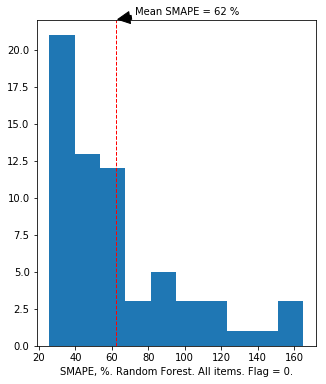

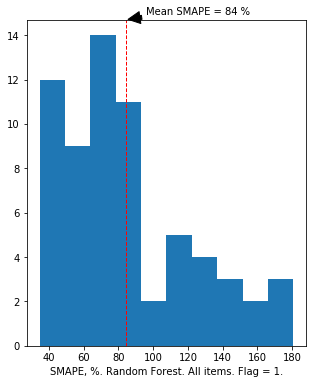

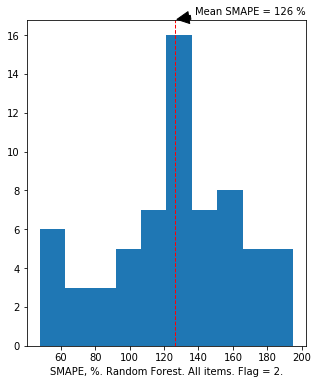

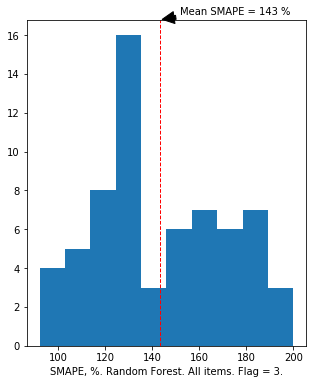

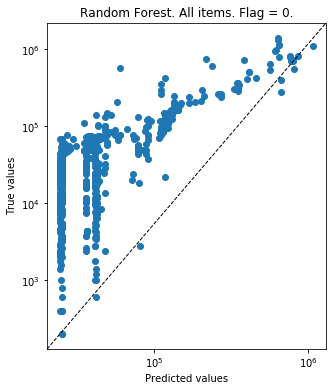

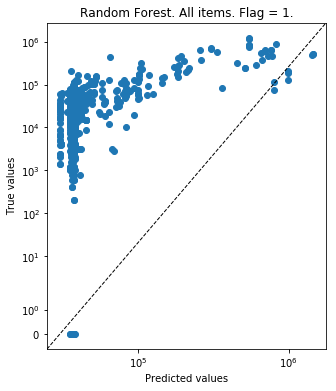

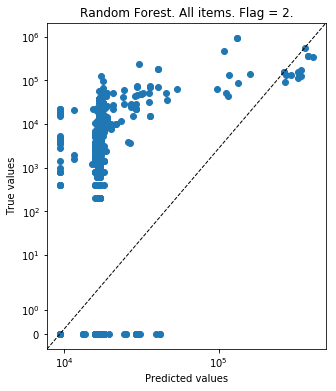

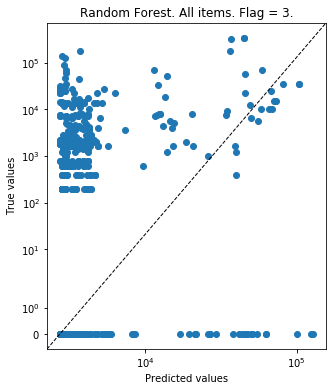

In [450]:
rf_true_,rf_pred_  = print_to_csv(y_predicted_rf_all,y_true_rf_all,"random_forest_all_items")
rf_true_0,rf_true_1,rf_true_2,rf_true_3 = create_dataframes_for_plots(rf_true_)
rf_pred_0,rf_pred_1,rf_pred_2,rf_pred_3= create_dataframes_for_plots(rf_pred_)
plot_array = [(rf_true_0,rf_pred_0),(rf_true_1,rf_pred_1),(rf_true_2,rf_pred_2),(rf_true_3,rf_pred_3)]
plot_hist(plot_array, "Random Forest. All items.",0)

### Random Forest. All items. Minmax transformation

In [594]:
y_predicted_rf_minmax_all, y_true_rf_minmax_all= prediction_all_values_minmax(exp_X,exp_Y,RandomForestRegressor(max_depth=3,n_estimators=100))

In [595]:
rf_log_true,rf_log_pred  = print_to_csv(y_predicted_rf_minmax_all,y_true_rf_minmax_all,"random_forest_all_items_minmax")
rf_true_0,rf_true_1,rf_true_2,rf_true_3 = create_dataframes_for_plots(rf_log_true)
rf_pred_0,rf_pred_1,rf_pred_2,rf_pred_3= create_dataframes_for_plots(rf_log_pred)
plot_array = [(rf_true_0,rf_pred_0),(rf_true_1,rf_pred_1),(rf_true_2,rf_pred_2),(rf_true_3,rf_pred_3)]
plot_hist(plot_array, "Random Forest. All items. Minmax Transform.")

### Random Forest. All items. Log transformation

In [596]:
y_predicted_rf_log_all, y_true_rf_log_all= prediction_all_values_logtransf(exp_X,exp_Y,RandomForestRegressor(max_depth=3,n_estimators=100))

In [597]:
rf_log_true,rf_log_pred  = print_to_csv(y_predicted_rf_log_all,y_true_rf_log_all,"random_forest_allitems_logtran")
rf_true_0,rf_true_1,rf_true_2,rf_true_3 = create_dataframes_for_plots(rf_log_true)
rf_pred_0,rf_pred_1,rf_pred_2,rf_pred_3= create_dataframes_for_plots(rf_log_pred)
plot_array = [(rf_true_0,rf_pred_0),(rf_true_1,rf_pred_1),(rf_true_2,rf_pred_2),(rf_true_3,rf_pred_3)]
plot_hist(plot_array, "Random Forest. All items. Log Transform.")

### Poisson. All items.

In [599]:
y_predicted, y_true= prediction_all_values(exp_X,exp_Y,xgboost.XGBRegressor( params={"objective": "count:poisson"},num_boost_round=100000,early_stopping_rounds=5,verbose_eval=False))

In [600]:
true_,pred_  = print_to_csv(y_predicted,y_true,"poisson_regression_all_items")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Poisson Regression. All items.")

### Poisson. All items. Minmax

In [601]:
y_predicted, y_true= prediction_all_values_minmax(exp_X,exp_Y,xgboost.XGBRegressor( params={"objective": "count:poisson"},num_boost_round=100000,early_stopping_rounds=5,verbose_eval=False))

In [602]:
true_,pred_  = print_to_csv(y_predicted,y_true,"poisson_regression_all_items_minmax")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Poisson Regression. All items. Minmax.")

### Poisson. All items. Log Transform.

In [603]:
y_predicted, y_true= prediction_all_values_logtransf(exp_X,exp_Y,xgboost.XGBRegressor( params={"objective": "count:poisson"},num_boost_round=100000,early_stopping_rounds=5,verbose_eval=False))

In [604]:
true_,pred_  = print_to_csv(y_predicted,y_true,"poisson_regression_all_items_logtran")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Poisson Regression. All items. Log transformation.")

### Neural Network. All items. 

In [606]:
y_predicted, y_true= prediction_all_values(exp_X,exp_Y, MLPRegressor(activation= 'tanh', hidden_layer_sizes= (20,), solver= 'lbfgs'))

In [607]:
true_,pred_  = print_to_csv(y_predicted,y_true,"neural_network_all_items")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Neural Network. All items.")

### Neural Network. All items. Minmax

In [608]:
y_predicted, y_true= prediction_all_values_minmax(exp_X,exp_Y,MLPRegressor(activation= 'tanh', hidden_layer_sizes= (20,), solver= 'lbfgs'))

In [609]:
true_,pred_  = print_to_csv(y_predicted,y_true,"neural_network_all_items_minmax")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Neural Network. All items. Minmax.")

### Neural Network. All items. Log Transform.

In [611]:
y_predicted, y_true= prediction_all_values_logtransf(exp_X,exp_Y,MLPRegressor(activation= 'tanh', hidden_layer_sizes= (20,), solver= 'lbfgs'))

In [612]:
true_,pred_  = print_to_csv(y_predicted,y_true,"neural_network_all_items_logtran")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Neural Network. All items. Log transformation.")

### Adaboost. All items.

In [616]:
ada_tree_backing = DecisionTreeRegressor(max_features='sqrt', splitter='random', min_samples_split=3, max_depth=3)
ab = AdaBoostRegressor(ada_tree_backing, learning_rate=0.1, loss='square', n_estimators=100)

In [617]:
y_predicted, y_true= prediction_all_values(exp_X,exp_Y,ab)

In [618]:
true_,pred_  = print_to_csv(y_predicted,y_true,"adaboost_all_items")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Adaboost. All items.")

### Adaboost. All items. Minmax

In [619]:
y_predicted, y_true= prediction_all_values_minmax(exp_X,exp_Y,ab)

In [620]:
true_,pred_  = print_to_csv(y_predicted,y_true,"adaboost_all_items_minmax")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Adaboost. All items. Minmax.")

### Adaboost. All items. Log Transform

In [621]:
y_predicted, y_true= prediction_all_values_logtransf(exp_X,exp_Y,ab)

In [622]:
true_,pred_  = print_to_csv(y_predicted,y_true,"adaboost_all_items_logtran")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Adaboost. All items. Log transform.")

### Kernel Regression. All items.

In [623]:
from sklearn.kernel_ridge import KernelRidge
kr = KernelRidge(alpha=1.0)

In [628]:
%%capture
y_predicted, y_true= prediction_all_values(exp_X,exp_Y,kr)

In [629]:
true_,pred_  = print_to_csv(y_predicted,y_true,"kernel_regression_all_items")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Kernel. All items.")

### Kernel Regression. All items. Minmax

In [646]:
%%capture
y_predicted, y_true= prediction_all_values_minmax(exp_X,exp_Y,kr)

In [647]:
true_,pred_  = print_to_csv(y_predicted,y_true,"kernel_regression_all_items_minmax")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Kernel. All items. Minmax.")

### Kernel Regression. All items. Log Transform

In [632]:
%%capture
y_predicted, y_true= prediction_all_values_logtransf(exp_X,exp_Y,kr)

In [633]:
true_,pred_  = print_to_csv(y_predicted,y_true,"kernel_regression_all_items_logtran")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Kernel. All items. Log transform.")

### Lasso. All items.

In [635]:
from sklearn.linear_model import Lasso
ls = Lasso(alpha=0.1)

In [638]:
%%capture
y_predicted, y_true= prediction_all_values(exp_X,exp_Y,ls)

C:\Users\Alexander\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [639]:
true_,pred_  = print_to_csv(y_predicted,y_true,"lasso_all_items")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Lasso. All items.")

### Lasso. All items. Minmax

In [644]:
%%capture
y_predicted, y_true= prediction_all_values_minmax(exp_X,exp_Y,ls)

In [645]:
true_,pred_  = print_to_csv(y_predicted,y_true,"lasso_all_items_minmax")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Lasso. All items. Minmax.")

### Lasso. All items. Log Transform

In [642]:
%%capture
y_predicted, y_true= prediction_all_values_logtransf(exp_X,exp_Y,ls)

In [643]:
true_,pred_  = print_to_csv(y_predicted,y_true,"lasso_all_items_logtran")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Lasso. All items. Log transform.")

### Ridge. All items.

In [648]:
from sklearn.linear_model import Ridge
rg =Ridge(alpha=1.0)

In [650]:
y_predicted, y_true= prediction_all_values(exp_X,exp_Y,rg)

In [651]:
true_,pred_  = print_to_csv(y_predicted,y_true,"ridge_all_items")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Ridge. All items.")

### Ridge. All items. Minmax

In [652]:
y_predicted, y_true= prediction_all_values_minmax(exp_X,exp_Y,rg)

In [653]:
true_,pred_  = print_to_csv(y_predicted,y_true,"ridge_all_items_minmax")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Ridge. All items. Minmax.")

### Ridge. All items. Log Transform

In [654]:
y_predicted, y_true= prediction_all_values_logtransf(exp_X,exp_Y,rg)

In [655]:
true_,pred_  = print_to_csv(y_predicted,y_true,"ridge_all_items_logtran")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Ridge. All items. Log transform.")

### SVR. All items.

In [659]:
from sklearn.svm import SVR
svrr = SVR(C=1.0, epsilon=0.2)

In [660]:
y_predicted, y_true= prediction_all_values(exp_X,exp_Y,svrr)

In [661]:
true_,pred_  = print_to_csv(y_predicted,y_true,"svr_all_items")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "SVR. All items.")

### SVR. All items. Minmax

In [662]:
y_predicted, y_true= prediction_all_values_minmax(exp_X,exp_Y,svrr)

In [663]:
true_,pred_  = print_to_csv(y_predicted,y_true,"svr_all_items_minmax")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "SVR. All items. Minmax.")

### SVR. All items. Log Transform

In [664]:
y_predicted, y_true= prediction_all_values_logtransf(exp_X,exp_Y,svrr)

In [665]:
true_,pred_  = print_to_csv(y_predicted,y_true,"svr_all_items_logtran")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "SVR. All items. Log transform.")

# Functions, which fits items one by one

In [737]:
def prediction_item_by_item_fit(exp_X_trunc,exp_Y_trunc,regrr):
    y_predicted = defaultdict()
    exp_Y_trunc = exp_Y_trunc.reindex(columns=['rpd','item',' 1-0',' 2-0',' 3-0',' 4-0',' 2-1',' 3-1',' 3-2',' 4-1',' 4-2',' 4-3'])
    y_true = defaultdict()
    for it in set(exp_X_trunc.item):
        y_predicted[it] = [[],[],[],[],[],[],[],[],[],[]]
        y_true[it] = [[],[],[],[],[],[],[],[],[],[]]
    for i in range(139,151):             
        for ii in range(1,11):
            for it in set(exp_X_trunc.item):
                regr = regrr
                X = exp_X_trunc.loc[exp_X_trunc['rpd'].isin(list(range(108,i+1)))]
                X = X.loc[X['item']==it].iloc[:,2:12]
                Y = exp_Y_trunc.loc[exp_Y_trunc['rpd'].isin(list(range(108,i+1)))]
                Y = Y.loc[Y['item']==it].iloc[:,ii+1]
                regr.fit(X,Y)          
                X_test = exp_X_trunc.loc[exp_X_trunc['rpd'].isin(list(range(i+1,i+2)))]
                X_test = X_test.loc[X_test['item']==it].iloc[:,2:12]
                if (X_test.size==0):
                    continue
                y_predicted[it][ii-1].append(regr.predict(X_test)[0])
                true_ = exp_Y_trunc.loc[exp_Y_trunc['rpd'].isin(list(range(i+1,i+2)))]
                true_ = true_.loc[true_['item']==it].iloc[:,ii+1].values[0]
                y_true[it][ii-1].append(true_)
    for x in y_predicted.keys():
        y_predicted[x] = pd.DataFrame(np.array(y_predicted[x]).clip(min=0).transpose())#.reindex(columns = [0,1,3,6,2,4,5,7,8,9])
        y_true[x] = pd.DataFrame(np.array(y_true[x]).transpose()).applymap(float)
    return y_predicted,y_true

In [738]:
def prediction_item_by_item_fit_minmax(exp_X_trunc,exp_Y_trunc,regrr):
    y_predicted = defaultdict()
    exp_Y_trunc = exp_Y_trunc.reindex(columns=['rpd','item',' 1-0',' 2-0',' 3-0',' 4-0',' 2-1',' 3-1',' 3-2',' 4-1',' 4-2',' 4-3'])
    y_true = defaultdict()
    for it in set(exp_X_trunc.item):
        y_predicted[it] = [[],[],[],[],[],[],[],[],[],[]]
        y_true[it] = [[],[],[],[],[],[],[],[],[],[]]
    for i in range(139,151):
        for ii in range(1,11):
            regr = regrr
            scaler = MinMaxScaler()
            X = exp_X_trunc.loc[exp_X_trunc['rpd'].isin(list(range(108,i+1)))]
            X = X.loc[X['item']==it].iloc[:,2:12]
            scaler_y = MinMaxScaler()
            Y = exp_Y_trunc.loc[exp_Y_trunc['rpd'].isin(list(range(108,i+1)))]
            Y = Y.loc[Y['item']==it].iloc[:,ii+1]
            Y = scaler_y.fit_transform( np.array([list(map(float,Y))]).transpose())
            X_scaled = scaler.fit_transform(X)
            regr.fit(X_scaled,np.array(Y).ravel())
            for it in set(exp_X_trunc.item):
                X_test = exp_X_trunc.loc[exp_X_trunc['rpd'].isin(list(range(i+1,i+2)))]
                X_test = X_test.loc[X_test['item']==it].iloc[:,2:12]
                if (X_test.size==0):
                    continue
                scaled_prediction = regr.predict( scaler.transform(X_test))[0]
                y_predicted[it][ii-1].append(  scaler_y.inverse_transform(scaled_prediction)[0][0])
                true_ = exp_Y_trunc.loc[exp_Y_trunc['rpd'].isin(list(range(i+1,i+2)))]
                true_ = true_.loc[true_['item']==it].iloc[:,ii+1].values[0]
                y_true[it][ii-1].append(true_)
    for x in y_predicted.keys():
        y_predicted[x] = pd.DataFrame(np.array(y_predicted[x]).clip(min=0).transpose())#.reindex(columns = [0,1,3,6,2,4,5,7,8,9])
        y_true[x] = pd.DataFrame(np.array(y_true[x]).transpose()).applymap(float)
    return y_predicted,y_true

In [739]:
def prediction_item_by_item_fit_logtran(exp_X_trunc,exp_Y_trunc,regrr):
    y_predicted = defaultdict()
    exp_Y_trunc = exp_Y_trunc.reindex(columns=['rpd','item',' 1-0',' 2-0',' 3-0',' 4-0',' 2-1',' 3-1',' 3-2',' 4-1',' 4-2',' 4-3'])
    y_true = defaultdict()
    for it in set(exp_X_trunc.item):
        y_predicted[it] = [[],[],[],[],[],[],[],[],[],[]]
        y_true[it] = [[],[],[],[],[],[],[],[],[],[]]
    for i in range(139,151):             
        for ii in range(1,11):
            regr = regrr
            X = exp_X_trunc.loc[exp_X_trunc['rpd'].isin(list(range(108,i+1)))]
            X = X.loc[X['item']==it].iloc[:,2:12]
            Y = exp_Y_trunc.loc[exp_Y_trunc['rpd'].isin(list(range(108,i+1)))]
            Y = Y.loc[Y['item']==it].iloc[:,ii+1]
            regr.fit(np.log1p(X),np.log1p(Y))
            for it in set(exp_X_trunc.item):
                X_test = exp_X_trunc.loc[exp_X_trunc['rpd'].isin(list(range(i+1,i+2)))]
                X_test = X_test.loc[X_test['item']==it].iloc[:,2:12]
                if (X_test.size==0):
                    continue
                y_predicted[it][ii-1].append(  np.expm1 (regr.predict(np.log1p(X_test))[0]))
                true_ = exp_Y_trunc.loc[exp_Y_trunc['rpd'].isin(list(range(i+1,i+2)))]
                true_ = true_.loc[true_['item']==it].iloc[:,ii+1].values[0]
                y_true[it][ii-1].append(true_)
    for x in y_predicted.keys():
        y_predicted[x] = pd.DataFrame(np.array(y_predicted[x]).clip(min=0).transpose())#.reindex(columns = [0,1,3,6,2,4,5,7,8,9])
        y_true[x] = pd.DataFrame(np.array(y_true[x]).transpose()).applymap(float)
    return y_predicted,y_true

### Adaboost. Item by item fit.

In [695]:
ada_tree_backing = DecisionTreeRegressor(max_features='sqrt', splitter='random', min_samples_split=3, max_depth=3)
ab = AdaBoostRegressor(ada_tree_backing, learning_rate=0.1, loss='square', n_estimators=100)

In [687]:
y_predicted, y_true= prediction_item_by_item_fit(exp_X,exp_Y,ab)

In [688]:
true_,pred_  = print_to_csv(y_predicted,y_true,"adaboost")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Adaboost.")

### Adaboost. Item by item fit. Minmax

In [700]:
y_predicted, y_true= prediction_item_by_item_fit_minmax(exp_X,exp_Y,ab)

In [701]:
true_,pred_  = print_to_csv(y_predicted,y_true,"adaboost_minmax")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Adaboost. Minmax.")

### Adaboost. Item by item fit. Log Transform

In [704]:
y_predicted, y_true= prediction_item_by_item_fit_logtran(exp_X,exp_Y,ab)

In [705]:
true_,pred_  = print_to_csv(y_predicted,y_true,"adaboost_logtran")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Adaboost. Log transform.")

### Kernel Regression.  Item by item fit.

In [740]:
from sklearn.kernel_ridge import KernelRidge
kr = KernelRidge(alpha=1.0)

In [741]:
%%capture
y_predicted, y_true= prediction_item_by_item_fit(exp_X,exp_Y,kr)

In [742]:
true_,pred_  = print_to_csv(y_predicted,y_true,"kernel_regression")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Kernel.")

### Kernel Regression.  Item by item fit. Minmax

In [743]:
%%capture
y_predicted, y_true= prediction_item_by_item_fit_minmax(exp_X,exp_Y,kr)

In [744]:
true_,pred_  = print_to_csv(y_predicted,y_true,"kernel_regression_minmax")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Kernel. Minmax.")

### Kernel Regression. Item by item fit. Log Transform

In [745]:
%%capture
y_predicted, y_true= prediction_item_by_item_fit_logtran(exp_X,exp_Y,kr)

In [746]:
true_,pred_  = print_to_csv(y_predicted,y_true,"kernel_regression_logtran")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Kernel. Log transform.")

### Lasso.  Item by item fit.

In [747]:
from sklearn.linear_model import Lasso
ls = Lasso(alpha=0.1)

In [748]:
%%capture
y_predicted, y_true= prediction_item_by_item_fit(exp_X,exp_Y,ls)

In [749]:
true_,pred_  = print_to_csv(y_predicted,y_true,"lasso")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Lasso.")

### Lasso. Item by item fit. Minmax

In [750]:
%%capture
y_predicted, y_true= prediction_item_by_item_fit_minmax(exp_X,exp_Y,ls)

In [751]:
true_,pred_  = print_to_csv(y_predicted,y_true,"lasso_minmax")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Lasso. Minmax.")

### Lasso. Item by item fit. Log Transform

In [752]:
%%capture
y_predicted, y_true= prediction_item_by_item_fit_logtran(exp_X,exp_Y,ls)

In [753]:
true_,pred_  = print_to_csv(y_predicted,y_true,"lasso_logtran")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Lasso. Log transform.")

### Ridge. Item by item fit.

In [754]:
from sklearn.linear_model import Ridge
rg =Ridge(alpha=1.0)

In [755]:
y_predicted, y_true= prediction_item_by_item_fit(exp_X,exp_Y,rg)

In [756]:
true_,pred_  = print_to_csv(y_predicted,y_true,"ridge")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Ridge.")

### Ridge. Item by item fit. Minmax

In [757]:
y_predicted, y_true= prediction_item_by_item_fit_minmax(exp_X,exp_Y,rg)

In [758]:
true_,pred_  = print_to_csv(y_predicted,y_true,"ridge_minmax")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Ridge. Minmax.")

### Ridge. Item by item fit. Log Transform

In [759]:
y_predicted, y_true= prediction_item_by_item_fit_logtran(exp_X,exp_Y,rg)

In [760]:
true_,pred_  = print_to_csv(y_predicted,y_true,"ridge_logtran")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "Ridge. Log transform.")

### SVR. Item by item fit.

In [761]:
from sklearn.svm import SVR
svrr = SVR(C=1.0, epsilon=0.2)

In [762]:
y_predicted, y_true= prediction_item_by_item_fit(exp_X,exp_Y,svrr)

In [763]:
true_,pred_  = print_to_csv(y_predicted,y_true,"svr")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "SVR.")

### SVR.  Item by item fit. Minmax

In [764]:
y_predicted, y_true= prediction_item_by_item_fit_minmax(exp_X,exp_Y,svrr)

In [765]:
true_,pred_  = print_to_csv(y_predicted,y_true,"svr_minmax")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "SVR. Minmax.")

### SVR. Item by item fit. Log Transform

In [766]:
y_predicted, y_true= prediction_item_by_item_fit_logtran(exp_X,exp_Y,svrr)

In [767]:
true_,pred_  = print_to_csv(y_predicted,y_true,"svr_logtran")
true_0,true_1,true_2,true_3 = create_dataframes_for_plots(true_)
pred_0,pred_1,pred_2,pred_3= create_dataframes_for_plots(pred_)
plot_array = [(true_0,pred_0),(true_1,pred_1),(true_2,pred_2),(true_3,pred_3)]
plot_hist(plot_array, "SVR. Log transform.")